В якості домашнього завдання вам пропонується створити нейронну мережу за допомогою механізмів Keras, яка буде __класифікувати__ товари із датасету `fasion_mnist`.

Вам належить запропонувати свою власну архітектуру мережі. Точність найнаївнішої, але адекватної нейромережі становить приблизно __91%__. Точність вашої моделі повинна бути `не нижчою` за цей показник. Щоб досягти таких значень вам знадобиться `поекспериментувати з гіперпараметрами мережі`:

- кількість шарів;

- кількість нейронів;

- функції активації;

- кількість епох;

- розмір батчу;

- вибір оптимізатора;

- різні техніки регуляризації і т.д.

Використайте вивчені `техніки виявлення проблем навчання` нейронної мережі, і потім `поекспериментуйте`.

Рішення оформіть у вигляді окремого ноутбука.

In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.activations import mish, relu, sigmoid, softmax
from tensorflow.keras.datasets import fashion_mnist
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras import losses
from keras import metrics
from keras import optimizers


2023-08-01 16:45:15.632590: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-01 16:45:15.654975: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-01 16:45:15.812662: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-01 16:45:15.813776: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-01 16:45:16.639562: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

### __Dataset__

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train.dtype, x_train[0].shape

(dtype('uint8'), (28, 28))

In [3]:
NUM_FEATURES = x_train[0].shape[0] * x_train[0].shape[1]

In [4]:
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# each sample (28x28) to 1x784
x_train, x_test = x_train.reshape([-1, NUM_FEATURES]), x_test.reshape([-1, NUM_FEATURES])
print(min(x_train.min(), x_test.min()))
maximum = max(x_train.max(), x_test.max()) # np.max([x_train.max(), x_test.max()]) 
maximum

0.0


255.0

In [5]:
# Normalize (min = 0)
x_train, x_test = x_train / maximum, x_test / maximum

In [6]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

In [7]:
max(y_train.max(), y_test.max()), min(y_train.min(), y_test.min())

(9, 0)

In [8]:
NUM_CLASSES = len(set(np.concatenate((y_train, y_test), axis=0)))
NUM_CLASSES

10

In [9]:
y_true = tf.one_hot(y_train, depth=NUM_CLASSES).numpy()
y_truev = tf.one_hot(y_test, depth=NUM_CLASSES).numpy()
y_true.shape, y_truev.shape

((60000, 10), (10000, 10))

### __Model__

- https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
- https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy

In [10]:
# number of hidden layers
n_layers = [el for el in range(1, 3)]  # 1, 2
n_of_neurons = [2**el for el in range(1, 8)] # [[2**el for el in range(1, 9)] for _ in n_layers]  # 7

activations = ['relu', 'sigmoid', 'softmax']  # 'mish',

optimizators = [optimizers.legacy.SGD, optimizers.legacy.RMSprop, optimizers.legacy.Adam]  # 3
learning_rates = [10**el for el in range(-3, -1)]  # 2
n_epoch = 100  # max limit
batch_sizes = [2**el for el in range(7, 10)]  # 3



In [11]:
n_hiddens_ = []  # list of different (by number) layers for different models
bundle_activations  = []  # list of various feature sets of activations of all layers for different models
for s in n_layers:
    for el in list(itertools.product(n_of_neurons, repeat=s)):
        n_hidden_i = []
        n_hidden_i.append(NUM_FEATURES)
        n_hidden_i.extend(el)
        n_hidden_i.append(NUM_CLASSES)

        n_hiddens_.append(n_hidden_i)

    for el in list(itertools.product(activations[:-1], repeat=s)):
        activat = []
        activat.extend(el)
        activat.append(activations[-1])

        bundle_activations.append(activat)
    

In [12]:
len(n_hiddens_), len(bundle_activations)

(56, 6)

In [13]:
# matching layers with models
cx = 0  # number of options
for set_layers in n_hiddens_:  # 584
    for act in bundle_activations:  # 39
        if len(set_layers) == (len(act) + 1):
            cx+=1

cx

210

In [14]:
def create_NN(n_hidden_: list, activation: list, optimizer=optimizers.SGD, learning_rate=0.1) -> Sequential:
    model = Sequential(name=f'''m-{''.join(map(str, [f'{i}-' for i in n_hidden_[1:-1]]))}{''.join(map(str, [f'{a}-' for a in activation[:-1]]))}{optimizer.__name__}-{learning_rate}''')
    n_layers = len(n_hidden_)
    for layer in range(1, n_layers):
        model.add(Dense(n_hidden_[layer], activation=activation[layer-1], input_shape=(n_hidden_[layer-1],)))

    model.compile(
                  optimizer=optimizer(learning_rate=learning_rate), # legacy
                  loss=losses.CategoricalCrossentropy(),  # 'categorical_crossentropy' losses.binary_crossentropy,
                  metrics=['accuracy']  # metrics.BinaryAccuracy()
                  )

    return model

In [45]:
models = []  # 9216 models # !!! more then 32 GB RAM!!!!, ... try 1260 = 28sec
for set_layers in n_hiddens_:  # 584
    for act in bundle_activations:  # 39
        if len(set_layers) == (len(act) + 1):  # 1024  -> 210
            for opt in optimizators:  # 3
                for lr in learning_rates:  # 2
                    models.append(create_NN(n_hidden_=set_layers, activation=act, optimizer=opt, learning_rate=lr))

In [46]:
models[0].name  # model(m)-n_layer_1-...-activ_fun_layer_1-...-optimizator-learning_rate:

'm-2-relu-SGD-0.001'

### __Training__

In [47]:
history = {}  # 27648 = 38+ days training
lucky_numbers = np.random.randint(1, len(models), size=5)
for num, model in enumerate(models):
    if num in lucky_numbers:
        for bs in batch_sizes:  # 3
            history[f'{model.name}({bs})'] = model.fit(
                                                        x_train,
                                                        y_true,
                                                        epochs=100,
                                                        batch_size=bs,
                                                        validation_data=(x_test, y_truev)
                                                        )

Epoch 1/100
469/469 [==============================] - 1s 2ms/step - loss: 2.2409 - accuracy: 0.1924 - val_loss: 2.1696 - val_accuracy: 0.3144
Epoch 2/100
469/469 [==============================] - 1s 2ms/step - loss: 2.0854 - accuracy: 0.3401 - val_loss: 2.0010 - val_accuracy: 0.3557
Epoch 3/100
469/469 [==============================] - 1s 2ms/step - loss: 1.9153 - accuracy: 0.3785 - val_loss: 1.8369 - val_accuracy: 0.3875
Epoch 4/100
469/469 [==============================] - 1s 2ms/step - loss: 1.7538 - accuracy: 0.4093 - val_loss: 1.6795 - val_accuracy: 0.4223
Epoch 5/100
469/469 [==============================] - 1s 2ms/step - loss: 1.5962 - accuracy: 0.4302 - val_loss: 1.5296 - val_accuracy: 0.4154
Epoch 6/100
469/469 [==============================] - 1s 1ms/step - loss: 1.4664 - accuracy: 0.4360 - val_loss: 1.4301 - val_accuracy: 0.4639
Epoch 7/100
469/469 [==============================] - 1s 2ms/step - loss: 1.3882 - accuracy: 0.4466 - val_loss: 1.3696 - val_accuracy: 0.4663

### __Error Analysis__

In [204]:
# print(history[0].history.keys())
""" 
loss - список, в якому зберігається історія змін помилки на навчальних даних залежно від епохи
val_loss - список, де зберігається історія змін помилки на тестових даних залежно від епохи
accuracy - список, в якому зберігається історія змін точності на навчальних даних залежно від епохи
val_accuracy - список, де зберігається історія змін точності на тестових даних залежно від епохи
"""

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


' \nloss - список, в якому зберігається історія змін помилки на навчальних даних залежно від епохи\nval_loss - список, де зберігається історія змін помилки на тестових даних залежно від епохи\naccuracy - список, в якому зберігається історія змін точності на навчальних даних залежно від епохи\nval_accuracy - список, де зберігається історія змін точності на тестових даних залежно від епохи\n'

In [15]:
def draw_2twin_2d(y00: np.array, y01: np.array, y10: np.array, y11: np.array, suptitle: str) -> None:
    x = range(1, len(y00) + 1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))

    axs[0].plot(x, y00, 'bo', label='Training loss')
    axs[0].plot(x, y01, 'g', label='Validation loss')
    axs[0].title.set_text('Training and validation loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(x, y10, 'bo', label='Training acc')
    axs[1].plot(x, y11, 'g', label='Validation acc')
    axs[1].title.set_text('Training and validation acc')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Acc')
    axs[1].legend()
    axs[1].grid()
    
    fig.suptitle(suptitle)
    # plt.legend()
    # plt.grid()
    axs[1].grid()
    plt.show()


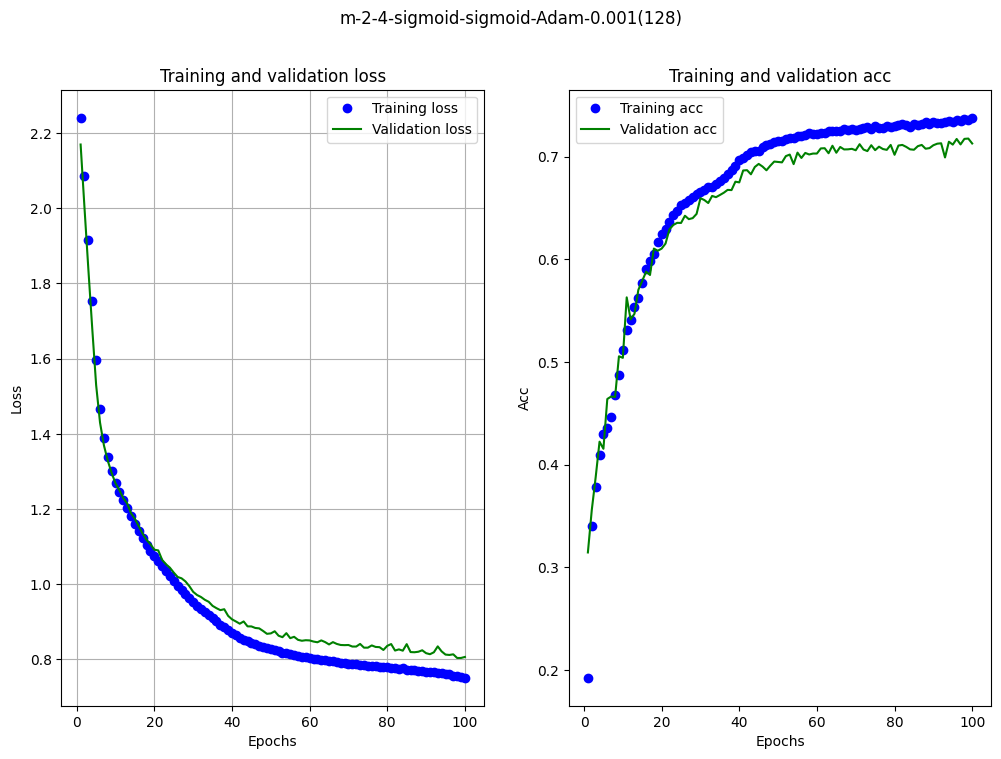

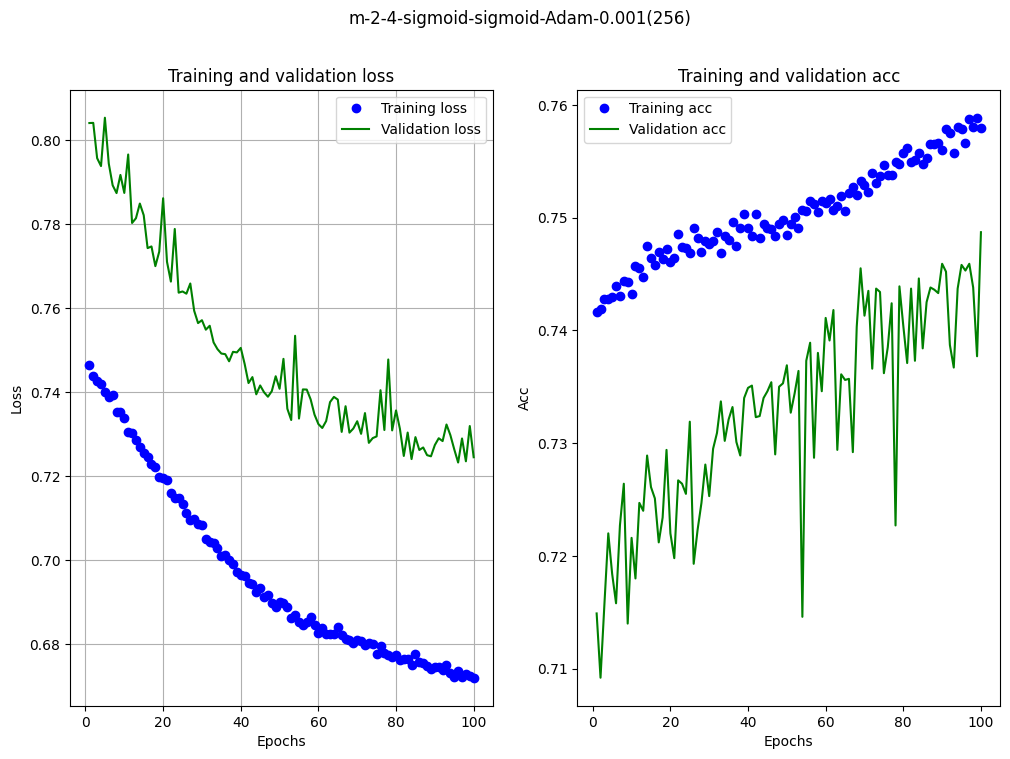

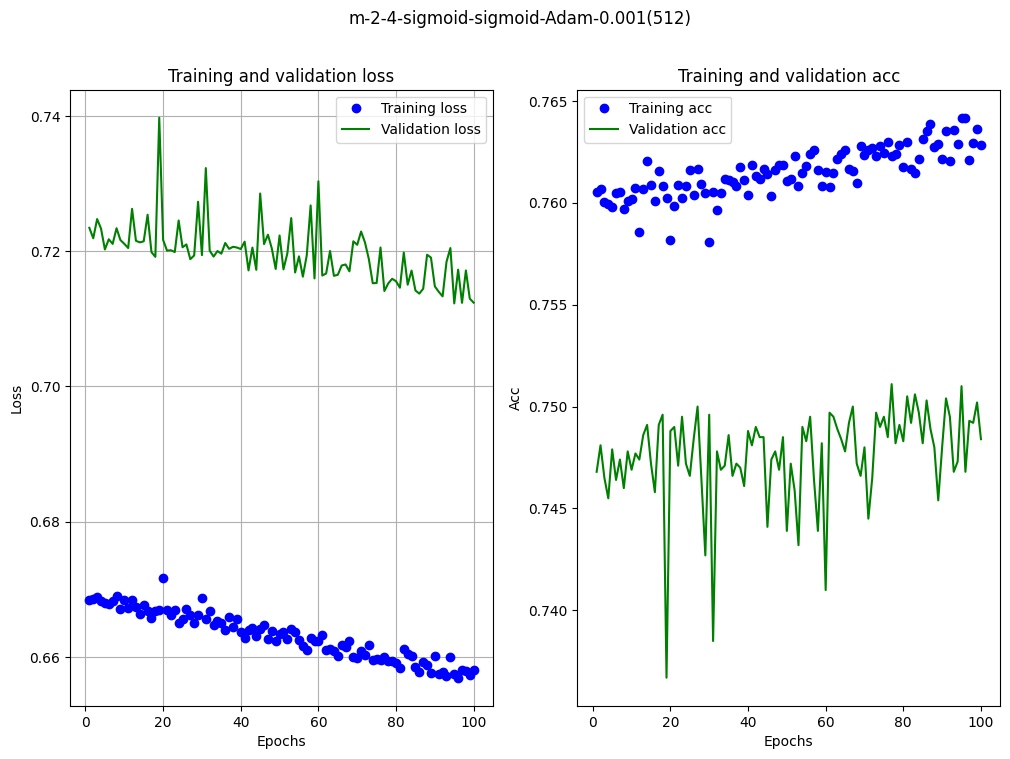

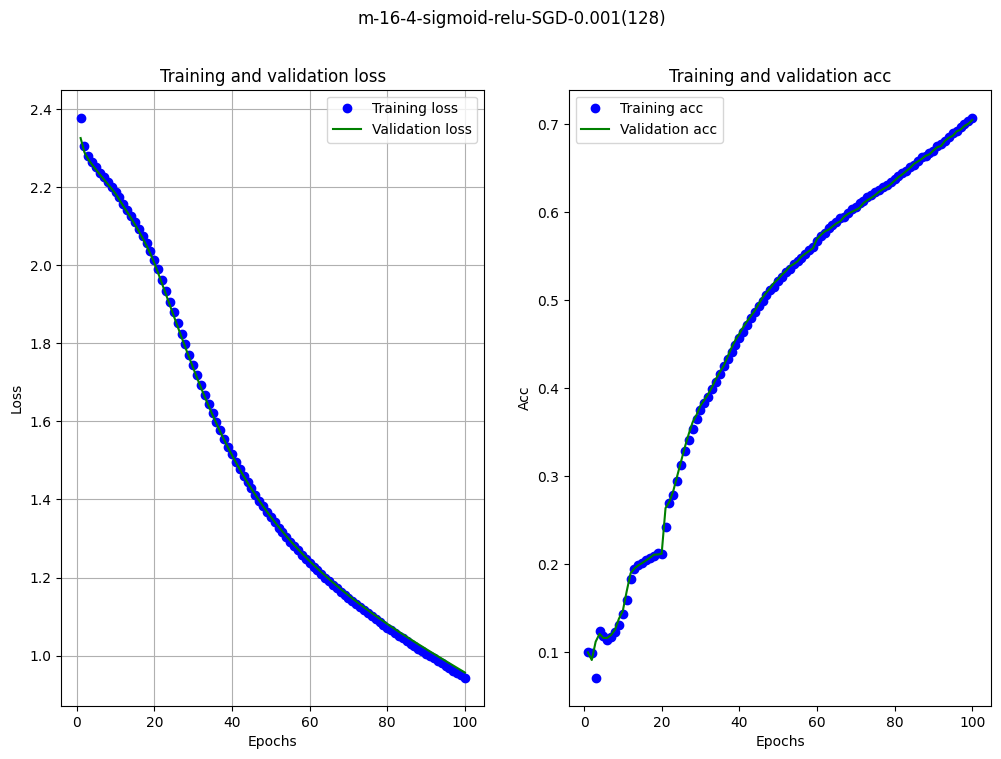

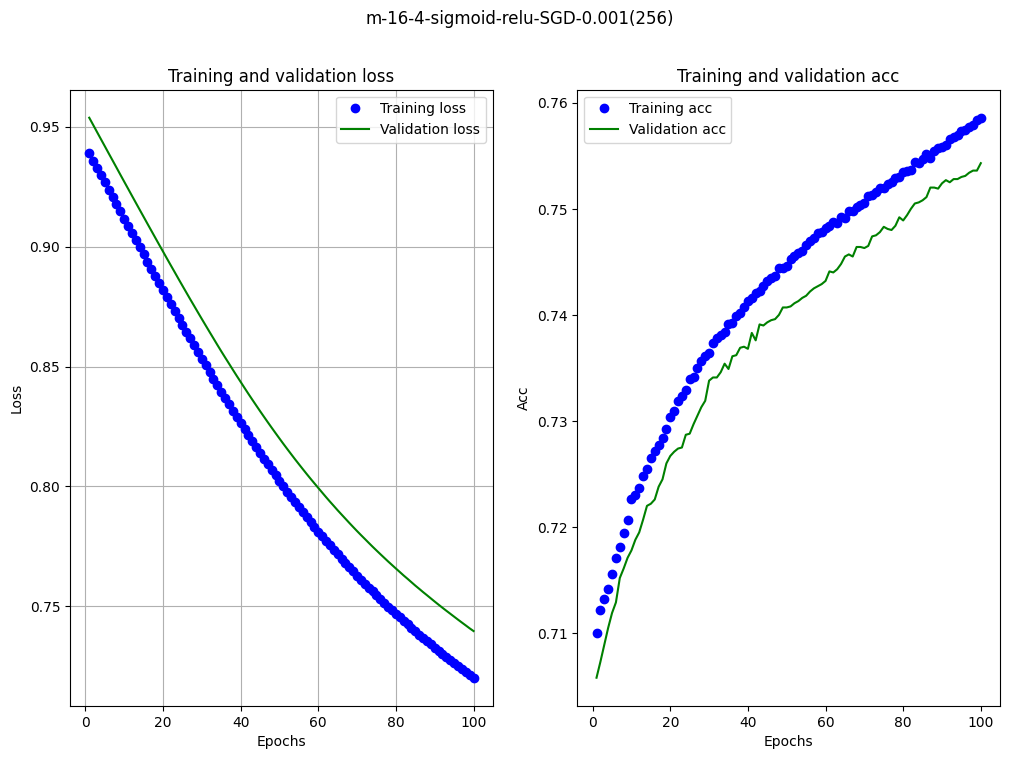

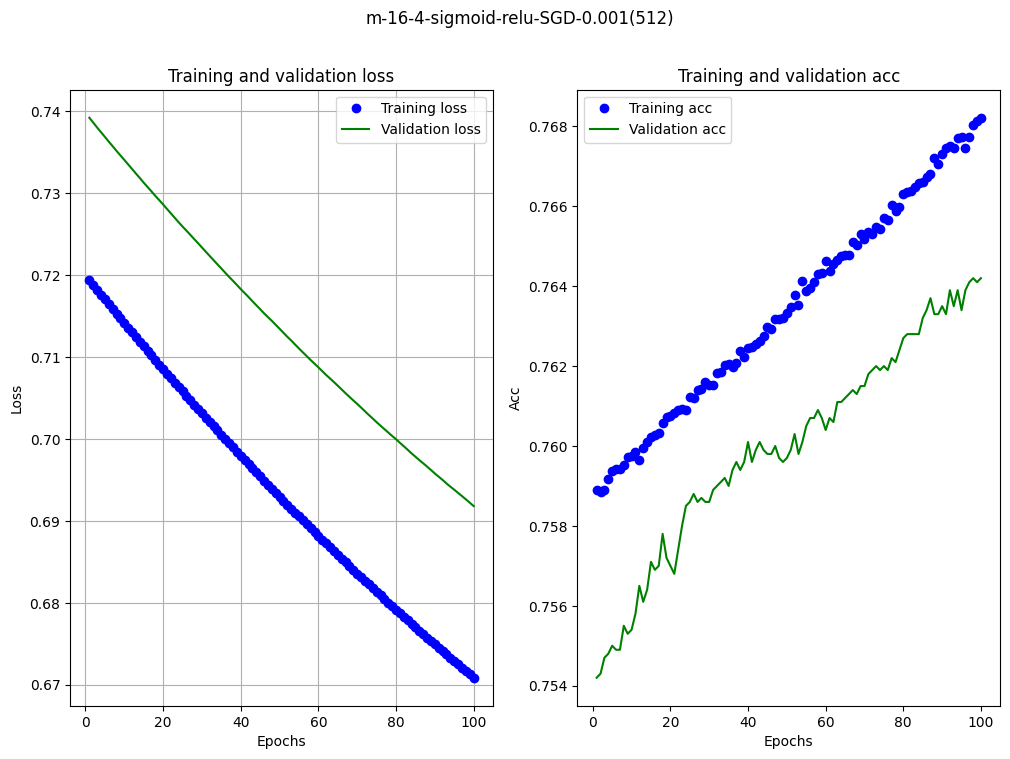

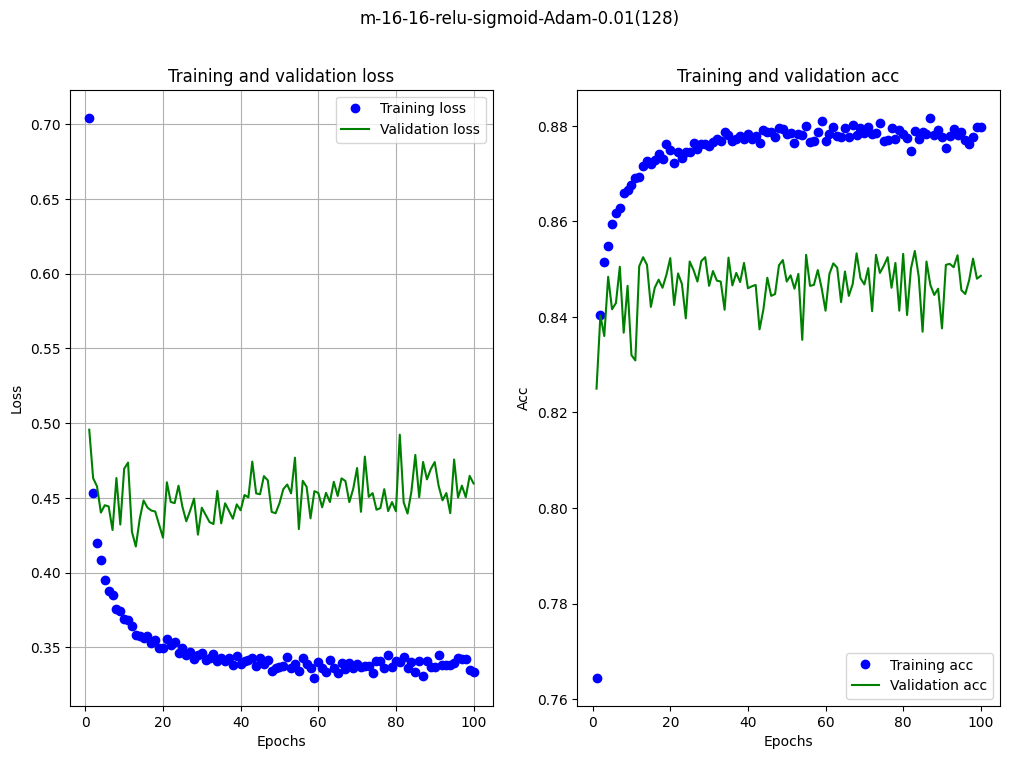

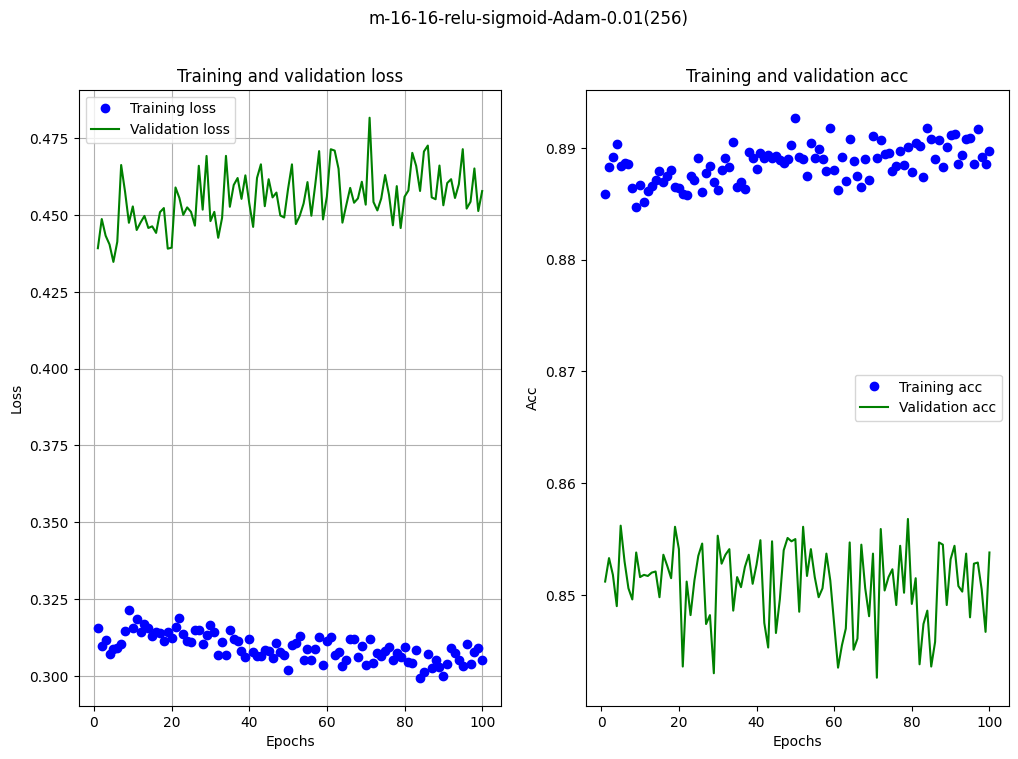

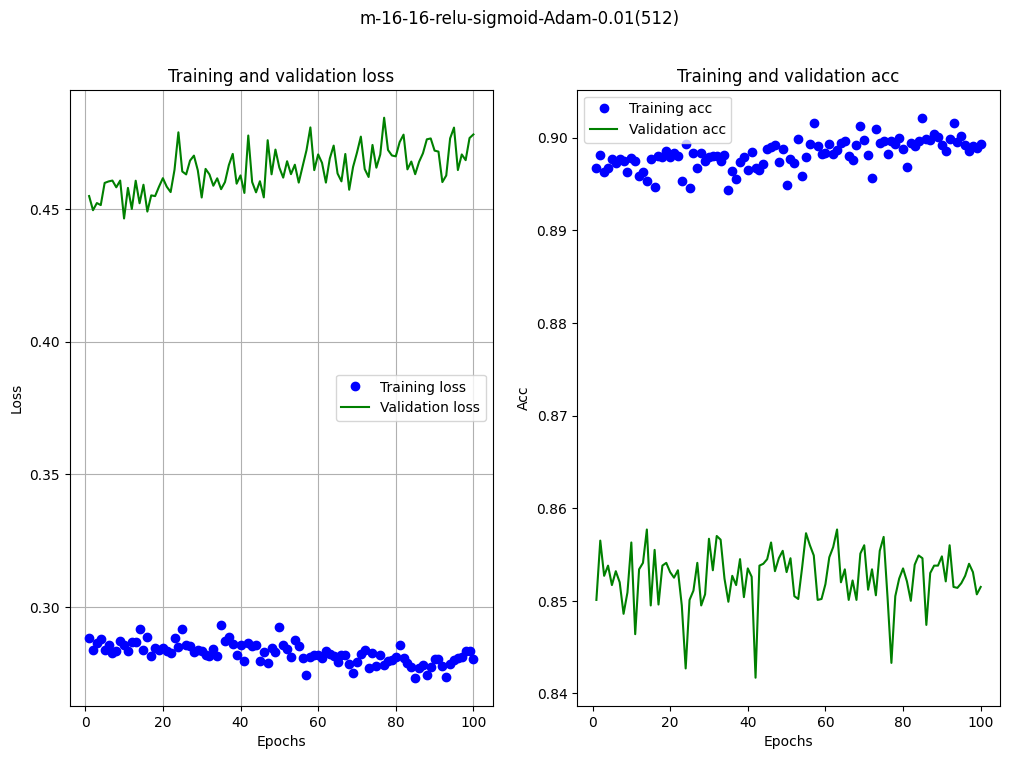

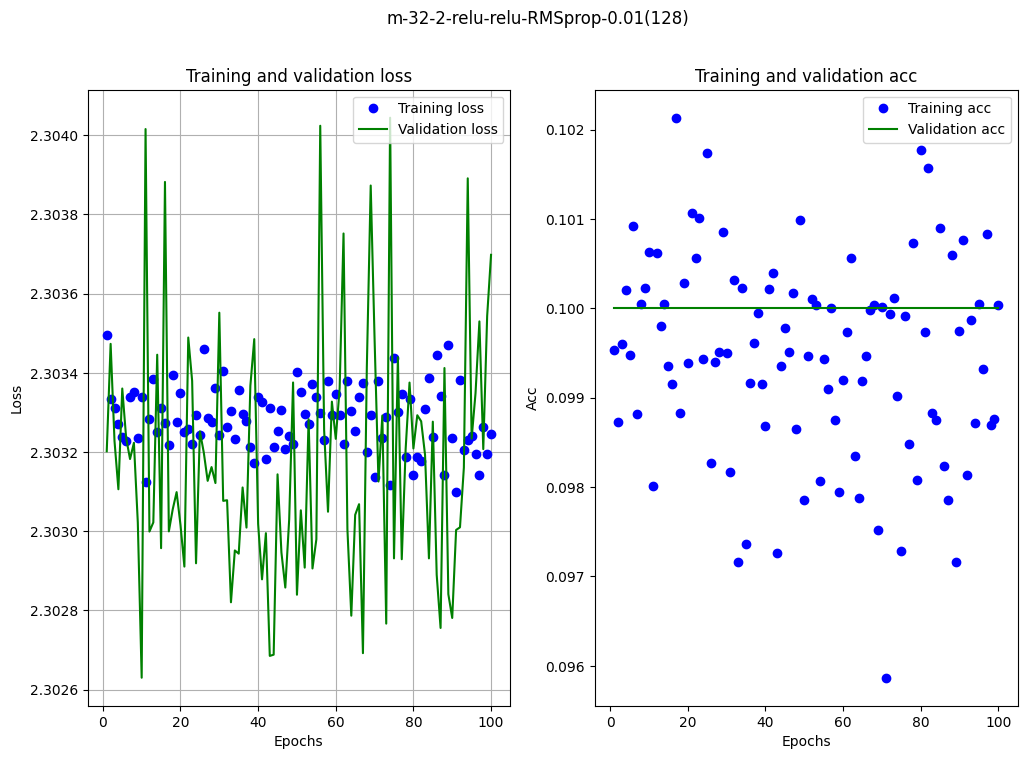

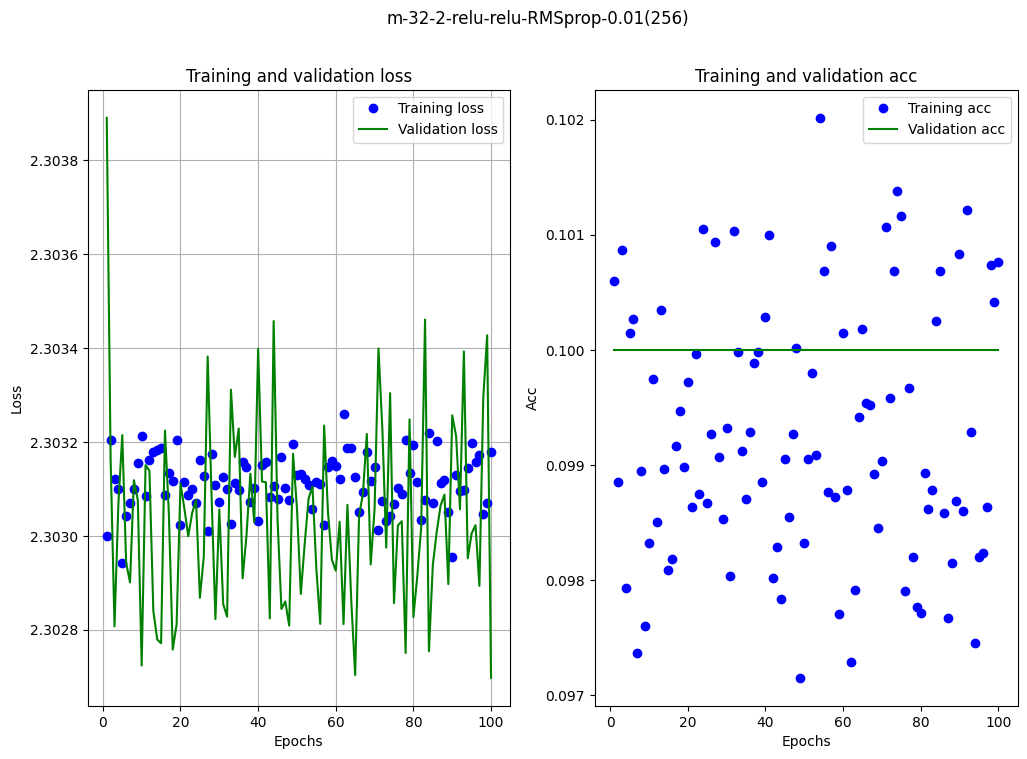

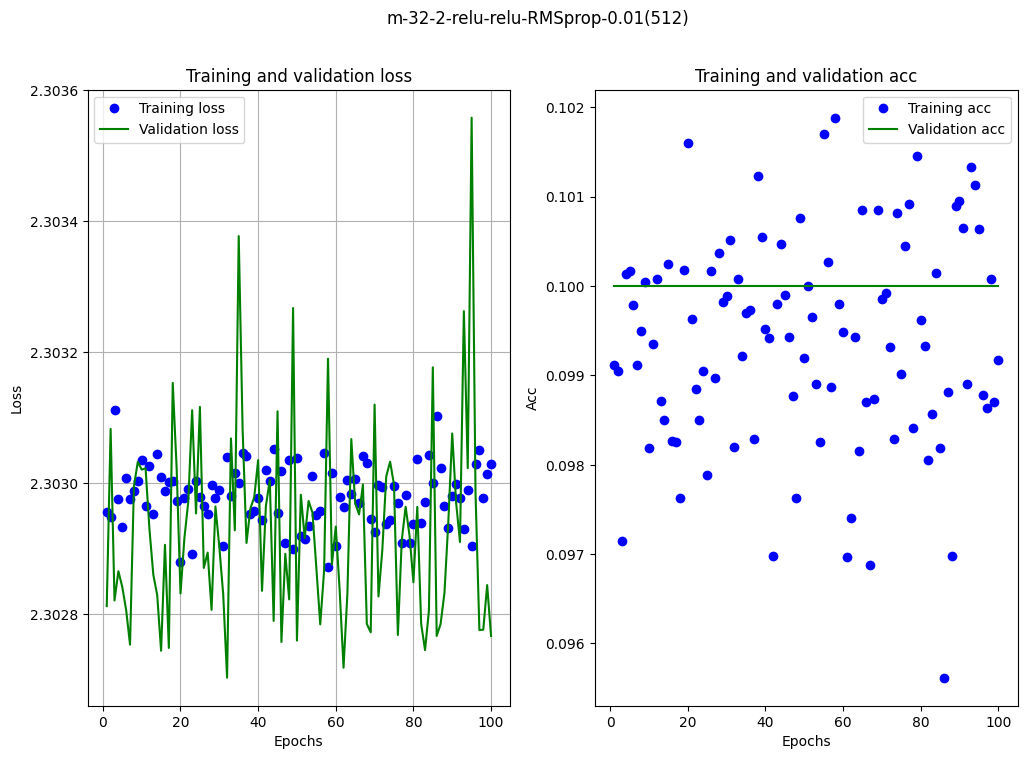

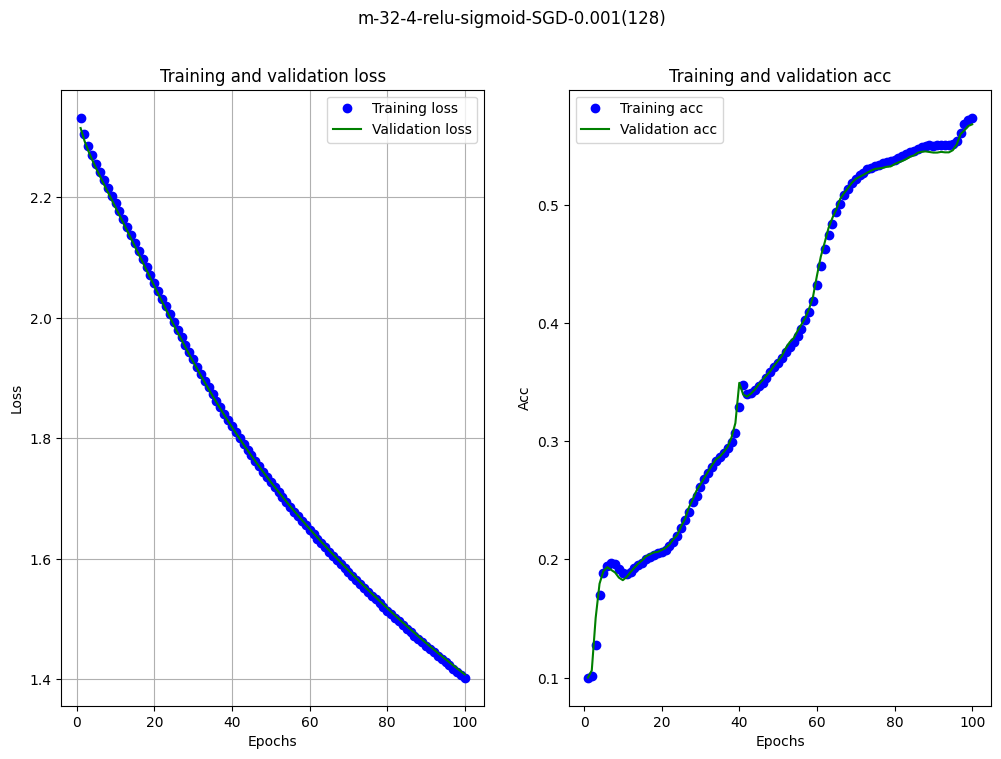

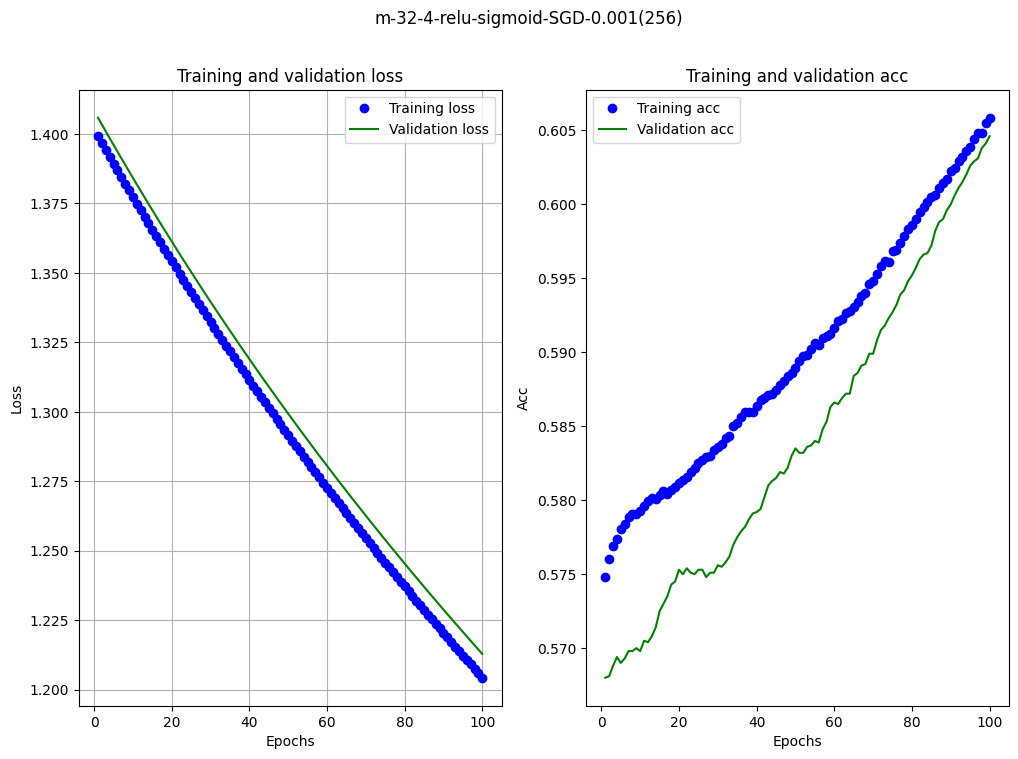

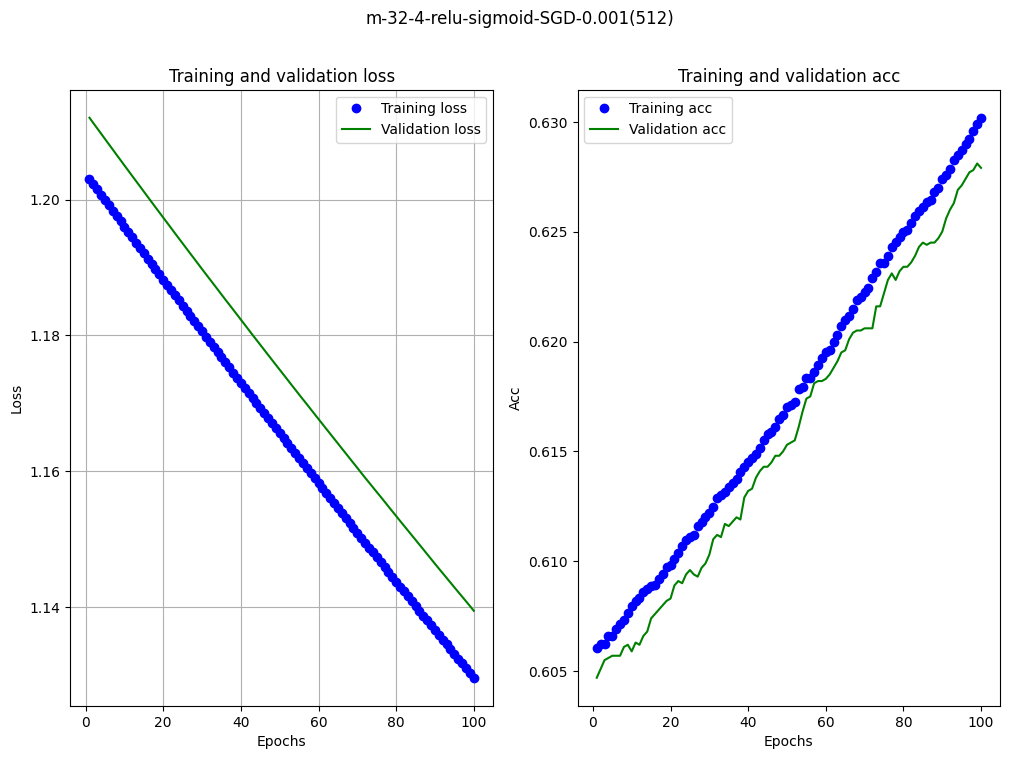

In [49]:
for model in history:
    history_dict = history[model].history

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']   

    draw_2twin_2d(loss_values, val_loss_values, acc_values, val_acc_values, suptitle=model)


### __Сonclusions 1__

Висновки: 
1) Якщо брати до уваги навіть частину деяких можливих значень гіперпараметрів, то кількість можливих варіантів моделей може бути достатньо велика (3 варіанти кількості шарів, 8 варіантів кількості нейронів кожного шару, 3 варіанти функції активації для кожного шару, 3 варіанти оптимізаторів, 3 варіанти швидкості навчання, 3 варіанти батчів і для 100 епох - тренування може тривати більше 38 днів, якщо вистачит оперативки для 27_648 моделей), що викликає сумніви в доцільності проведення дослідження значної кількості моделей.
2) За рандомного обирання деяких моделей з параметрами з певної вибірки можна сказати, що деякі моделі за результатами мають деяку подібну схожість, а логіка деяких взагалі сумнівна при певних параметрах.<br><br>
Для двошарової моделі з кількістю нейронів 2 та 4 на внітрішніх шарах з однаковою функцією активації(сигмоїда), алгоритмом активації Adam, швидкістю навчання 0.001 та батчі 128 видно:
- зі збільшенням епох видно зменшення втрат як для тренувалної, так і для валідаційної вибірки, причому близько 10ї епохи 'валідаційні' втрати починають перевищувати тренувальні, що свідчить про перенавчання;
- зі збільшенням епох видно збільшення точності як для тренувалної, так і для валідаційної вибірки, причому близько 10ї епохи 'валідаційна' точність стає меншою за тренувальну, що свідчить про перенавчання;
<br>
Для для такої ж моделі але батчі 256 видно:
- зі збільшенням епох втрати спадають а точність зростає, але за графіками схоже що 100 епох виявилось недостатнім для навчання, хоча втрати навчання менші за валідаціні, а точність більша;
<br>
Для для такої ж моделі але батчі 512 видно:
- зі збільшенням епох втрати ледь спадають а точність ледь зростає, але за графіками схоже що 100 епох виявилось недостатнім для навчання, хоча втрати навчання менші за валідаціні, а точність більша;
<br>
<br>
Для двошарової моделі з кількістю нейронів 16 та 4 на внітрішніх шарах з функціями активації(сигмоїда та relu відповідно), алгоритмом активації SGD, швидкістю навчання 0.001 та батчі 128 видно:
- зі збільшенням епох видно зменшення втрат як для тренувалної, так і для валідаційної вибірки, приблизно однакові значееня втрат для обох вибірок, але близько 35ї епохи втрати тренувальної вибірки починають ставати трішки меншими за валідаціні, що може свідчити про перенавчання, але ...
- зі збільшенням епох видно збільшення точності як для тренувалної, так і для валідаційної вибірки, причому за точністю меншою 0.8 і приблизно однаковими значеенями для обох вибірок можна вважати наявне недонавчання, хоча близько 60ї епохи значення точності тренувальної вибірки трішки починає перевищувати за валідаціну;
<br>
Для для такої ж моделі але батчі 256 видно:
- зі збільшенням епох втрати спадають а точність зростає, але за графіками схоже що 100 епох виявилось недостатнім для навчання, хоча втрати навчання менші за валідаціні і стаю все більшою з новою епохою, а точність - більшою;
<br>
Для для такої ж моделі але батчі 512 видно аналогічний характер попереднього варіанту (256 батчів) але більш прямолінійний схил. 
<br>
<br>
Для двошарової моделі з кількістю нейронів 16 на кожному з внітрішніх шарів з функціями активації(relu та сигмоїда відповідно), алгоритмом активації Adam, швидкістю навчання 0.01 та батчі 128 видно:
- зі збільшенням епох видно зменшення втрат як для тренувалної, так і для валідаційної вибірки, причому близько 15ї епохи 'валідаційні' втрати починають зростати, що свідчить про перенавчання;
- зі збільшенням епох видно збільшення точності тренувалної, а для валідаційної вибірки коливання з незначним зростанням;
<br>
Для для такої ж моделі але батчах 256 та 512 видно:
- зі збільшенням епох 'тренувальні' втрати трішки спадають а точність зростає, але для валідаціної вибірки втрати коливаються але усереднено зростаютьс а вцілому значно перевищують тренувальні, схоже що така модель при таких умовах може взагалі бути нездатною начитися за таких умов;
<br>
<br>
Для двошарової моделі з кількістю нейронів 32 та 2 на внітрішніх шарах з функціями активації(relu), алгоритмом активації RMSprop, швидкістю навчання 0.01 та різних батчах видно:
- хаотичне коливання значень (внаслідок певних алгоритмів та параметрів моделі) втрат та точності, причому за особливістю точність валідаційної вибірки стабільно 0.1, занадто невдала модель(у поєднанні з параметрами) у даному випадку.
<br>
<br>
Для двошарової моделі з кількістю нейронів 32 та 4 на внітрішніх шарах з функціями активації(relu та сигмоїда відповідно), алгоритмом активації SGD, швидкістю навчання 0.001 та батчі 128 видно:
- зі збільшенням епох видно зменшення втрат як для тренувалної, так і для валідаційної вибірки, причому близько 40ї епохи 'валідаційні' втрати починають перевищувати тренувальні, що може свідчити про перенавчання;
- зі збільшенням епох видно збільшення точності як для тренувалної, так і для валідаційної вибірки, причому наявні деякі вискоки з поперемінною перевагою то валідаціної то тренувальної точності, близько 60ї епохи 'валідаційна' точність стає трохи меншою за тренувальну, що може свідчити про перенавчання, але точність обох вибірок ще зростає;
<br>
Для для такої ж моделі але батчі 256 видно:
- зі збільшенням епох втрати спадають а точність зростає, але за графіками схоже що втрати валідаційної вибірки трішки все менше спадать за тренувальні, але точність за валідаційною вибіркою зі збільшенням епох ісе більше і більше зменшує розрив з тренувальною.
<br>
Для для такої ж моделі але батчі 512 видно:
- зі збільшенням епох втрати ледь спадають а точність ледь зростає(за значеннями), але за графіками схоже що 100 епох виявилось недостатнім для навчання, хоча втрати навчання менші за валідаціні, а точність більша - залежності майже паралельні;
<br><br>
3) Схоже надто багата варіативність залежить також від початкових вхідних даних, тому можливо доцільніше буде обрати якийсь варіант моделі за методом Стеля і змінювати почергово гіперпараметри шукаючи кращий варіант від початкового.

### __repeating__

In [18]:
def retest_NN(set_layers: list, act: list, opt: optimizers, lr: float, bs: int, epochs: int=100) -> None:
    """For retest one model."""
    models = [create_NN(
                        n_hidden_=set_layers, 
                        activation=act, 
                        optimizer=opt, 
                        learning_rate=lr
                        )] 

    history = {}
    history[f'{models[0].name}({bs})'] = models[0].fit(
                                                       x_train,
                                                       y_true,
                                                       epochs=epochs,
                                                       batch_size=bs,
                                                       validation_data=(x_test, y_truev)
                                                       )

    for model in history:
        history_dict = history[model].history

        loss_values = history_dict['loss']
        val_loss_values = history_dict['val_loss']
        acc_values = history_dict['accuracy']
        val_acc_values = history_dict['val_accuracy']   

        draw_2twin_2d(loss_values, val_loss_values, acc_values, val_acc_values, suptitle=model)

### __run__

Epoch 1/100
235/235 [==============================] - 1s 2ms/step - loss: 2.2911 - accuracy: 0.1190 - val_loss: 2.2684 - val_accuracy: 0.1299
Epoch 2/100
235/235 [==============================] - 1s 2ms/step - loss: 2.2577 - accuracy: 0.1291 - val_loss: 2.2490 - val_accuracy: 0.1290
Epoch 3/100
235/235 [==============================] - 0s 2ms/step - loss: 2.2404 - accuracy: 0.1402 - val_loss: 2.2334 - val_accuracy: 0.1344
Epoch 4/100
235/235 [==============================] - 0s 2ms/step - loss: 2.2253 - accuracy: 0.1684 - val_loss: 2.2184 - val_accuracy: 0.1467
Epoch 5/100
235/235 [==============================] - 0s 2ms/step - loss: 2.2093 - accuracy: 0.2053 - val_loss: 2.2017 - val_accuracy: 0.2523
Epoch 6/100
235/235 [==============================] - 0s 2ms/step - loss: 2.1911 - accuracy: 0.2584 - val_loss: 2.1827 - val_accuracy: 0.2666
Epoch 7/100
235/235 [==============================] - 0s 2ms/step - loss: 2.1711 - accuracy: 0.2721 - val_loss: 2.1632 - val_accuracy: 0.2738

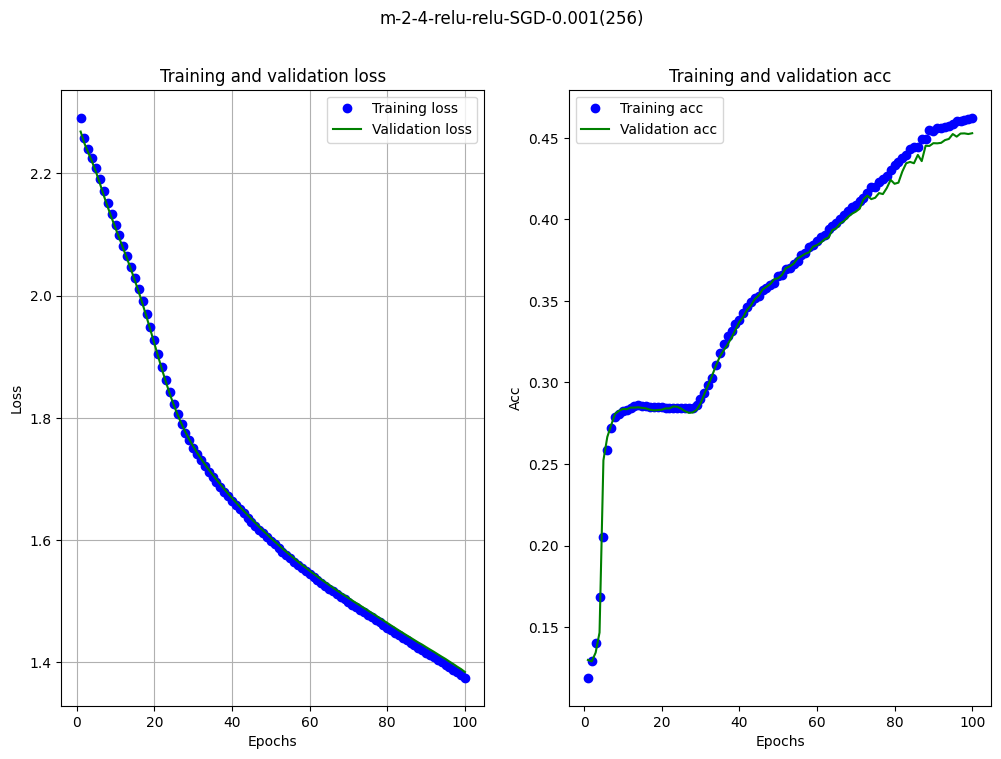

In [19]:
retest_NN(
          set_layers=[NUM_FEATURES, 2, 4, NUM_CLASSES], 
          act=['relu', 'relu', 'softmax'], 
          opt=optimizers.legacy.SGD, 
          lr=0.001,
          bs=256,
          )

недостатня точність при багатьох епохах, наявні ознаки перенавчання...

Epoch 1/100
235/235 [==============================] - 1s 2ms/step - loss: 2.3298 - accuracy: 0.1000 - val_loss: 2.3285 - val_accuracy: 0.1000
Epoch 2/100
235/235 [==============================] - 0s 2ms/step - loss: 2.3273 - accuracy: 0.1000 - val_loss: 2.3261 - val_accuracy: 0.1000
Epoch 3/100
235/235 [==============================] - 0s 2ms/step - loss: 2.3250 - accuracy: 0.1000 - val_loss: 2.3239 - val_accuracy: 0.1000
Epoch 4/100
235/235 [==============================] - 0s 2ms/step - loss: 2.3229 - accuracy: 0.1000 - val_loss: 2.3219 - val_accuracy: 0.1000
Epoch 5/100
235/235 [==============================] - 0s 2ms/step - loss: 2.3209 - accuracy: 0.1000 - val_loss: 2.3200 - val_accuracy: 0.1000
Epoch 6/100
235/235 [==============================] - 0s 2ms/step - loss: 2.3191 - accuracy: 0.1000 - val_loss: 2.3183 - val_accuracy: 0.1000
Epoch 7/100
235/235 [==============================] - 0s 2ms/step - loss: 2.3175 - accuracy: 0.1000 - val_loss: 2.3167 - val_accuracy: 0.1000

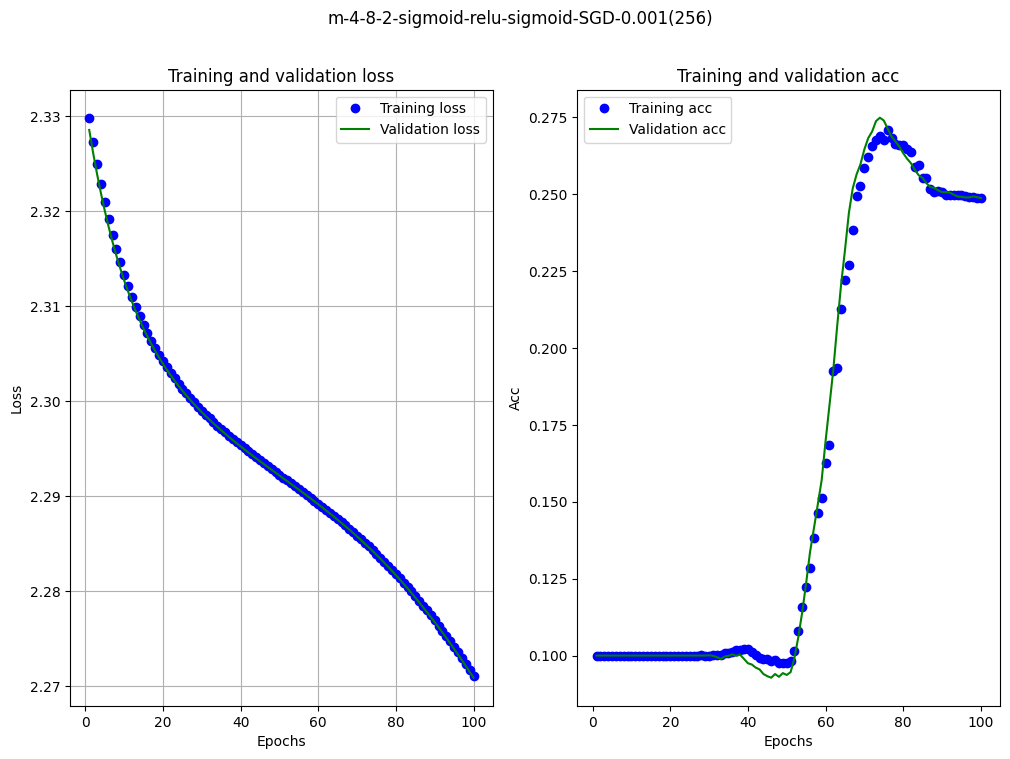

In [20]:
retest_NN(
          set_layers=[NUM_FEATURES, 4, 8, 2, NUM_CLASSES], 
          act=['sigmoid', 'relu', 'sigmoid', 'softmax'], 
          opt=optimizers.legacy.SGD, 
          lr=0.001,
          bs=256,
          )

недостатня точність при багатьох епохах, наявні ознаки перенавчання... зависока складніть моделі...

Epoch 1/100
235/235 [==============================] - 1s 2ms/step - loss: 2.2880 - accuracy: 0.1003 - val_loss: 2.2699 - val_accuracy: 0.1007
Epoch 2/100
235/235 [==============================] - 0s 2ms/step - loss: 2.2534 - accuracy: 0.1015 - val_loss: 2.2383 - val_accuracy: 0.1030
Epoch 3/100
235/235 [==============================] - 0s 2ms/step - loss: 2.2241 - accuracy: 0.0965 - val_loss: 2.2114 - val_accuracy: 0.0937
Epoch 4/100
235/235 [==============================] - 0s 2ms/step - loss: 2.1992 - accuracy: 0.0959 - val_loss: 2.1889 - val_accuracy: 0.0995
Epoch 5/100
235/235 [==============================] - 0s 2ms/step - loss: 2.1783 - accuracy: 0.1050 - val_loss: 2.1696 - val_accuracy: 0.1087
Epoch 6/100
235/235 [==============================] - 0s 2ms/step - loss: 2.1598 - accuracy: 0.1155 - val_loss: 2.1520 - val_accuracy: 0.1205
Epoch 7/100
235/235 [==============================] - 0s 2ms/step - loss: 2.1426 - accuracy: 0.1284 - val_loss: 2.1354 - val_accuracy: 0.1336

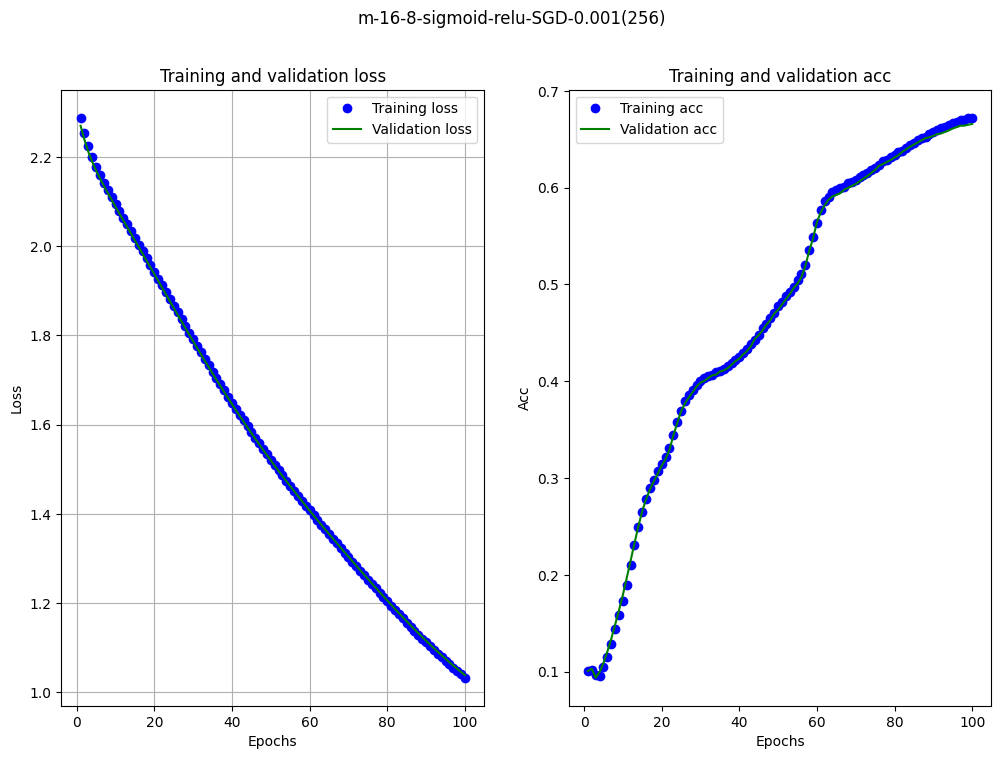

In [21]:
retest_NN(
          set_layers=[NUM_FEATURES, 16, 8, NUM_CLASSES], 
          act=['sigmoid', 'relu', 'softmax'], 
          opt=optimizers.legacy.SGD, 
          lr=0.001,
          bs=256,
          )

недостатня точність при багатьох епохах, наявні ознаки настання перенавчання...

Epoch 1/100
235/235 [==============================] - 1s 3ms/step - loss: 2.3980 - accuracy: 0.1077 - val_loss: 2.3279 - val_accuracy: 0.1361
Epoch 2/100
235/235 [==============================] - 1s 3ms/step - loss: 2.2911 - accuracy: 0.1747 - val_loss: 2.2620 - val_accuracy: 0.2029
Epoch 3/100
235/235 [==============================] - 1s 3ms/step - loss: 2.2395 - accuracy: 0.2373 - val_loss: 2.2209 - val_accuracy: 0.2674
Epoch 4/100
235/235 [==============================] - 1s 3ms/step - loss: 2.2020 - accuracy: 0.3060 - val_loss: 2.1859 - val_accuracy: 0.3286
Epoch 5/100
235/235 [==============================] - 1s 3ms/step - loss: 2.1673 - accuracy: 0.3521 - val_loss: 2.1510 - val_accuracy: 0.3680
Epoch 6/100
235/235 [==============================] - 1s 3ms/step - loss: 2.1305 - accuracy: 0.3831 - val_loss: 2.1124 - val_accuracy: 0.3959
Epoch 7/100
235/235 [==============================] - 1s 3ms/step - loss: 2.0905 - accuracy: 0.4187 - val_loss: 2.0721 - val_accuracy: 0.4362

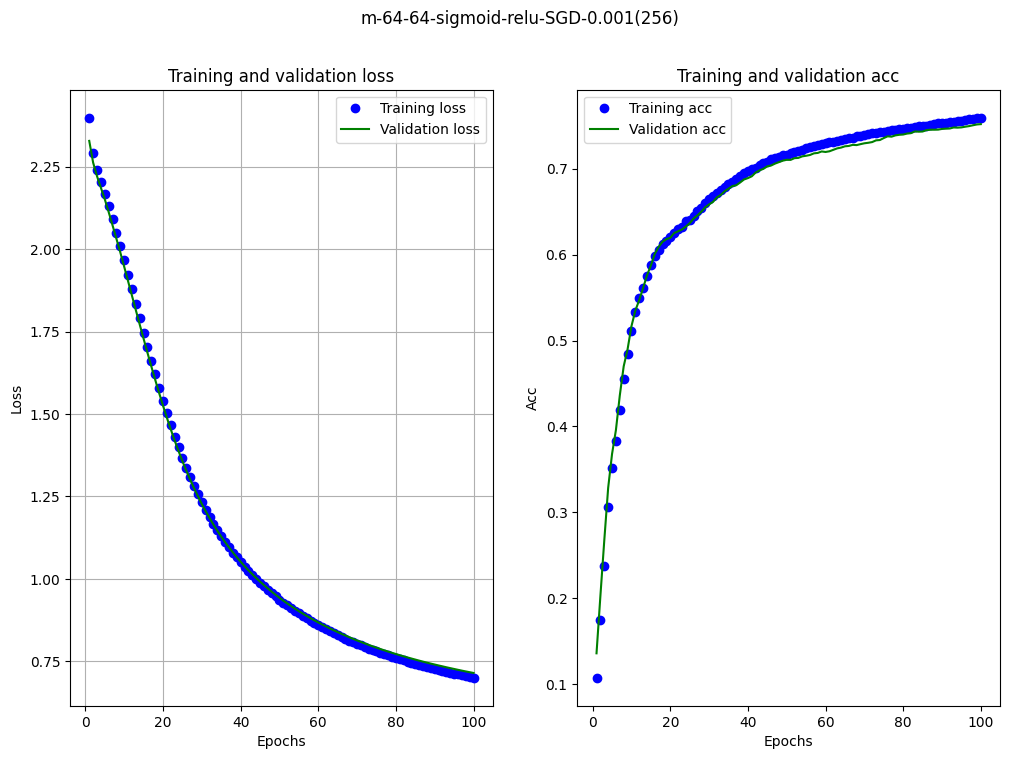

In [22]:
retest_NN(
          set_layers=[NUM_FEATURES, 64, 64, NUM_CLASSES], 
          act=['sigmoid', 'relu', 'softmax'], 
          opt=optimizers.legacy.SGD, 
          lr=0.001,
          bs=256,
          )

зараннє настання перенавчання...

Epoch 1/100
235/235 [==============================] - 1s 3ms/step - loss: 2.2900 - accuracy: 0.1963 - val_loss: 2.2567 - val_accuracy: 0.2265
Epoch 2/100
235/235 [==============================] - 1s 3ms/step - loss: 2.2301 - accuracy: 0.2519 - val_loss: 2.2060 - val_accuracy: 0.2846
Epoch 3/100
235/235 [==============================] - 1s 3ms/step - loss: 2.1848 - accuracy: 0.3455 - val_loss: 2.1644 - val_accuracy: 0.3917
Epoch 4/100
235/235 [==============================] - 1s 3ms/step - loss: 2.1437 - accuracy: 0.4313 - val_loss: 2.1234 - val_accuracy: 0.4568
Epoch 5/100
235/235 [==============================] - 1s 3ms/step - loss: 2.1019 - accuracy: 0.4772 - val_loss: 2.0811 - val_accuracy: 0.4871
Epoch 6/100
235/235 [==============================] - 1s 3ms/step - loss: 2.0586 - accuracy: 0.5029 - val_loss: 2.0367 - val_accuracy: 0.5165
Epoch 7/100
235/235 [==============================] - 1s 3ms/step - loss: 2.0128 - accuracy: 0.5246 - val_loss: 1.9905 - val_accuracy: 0.5218

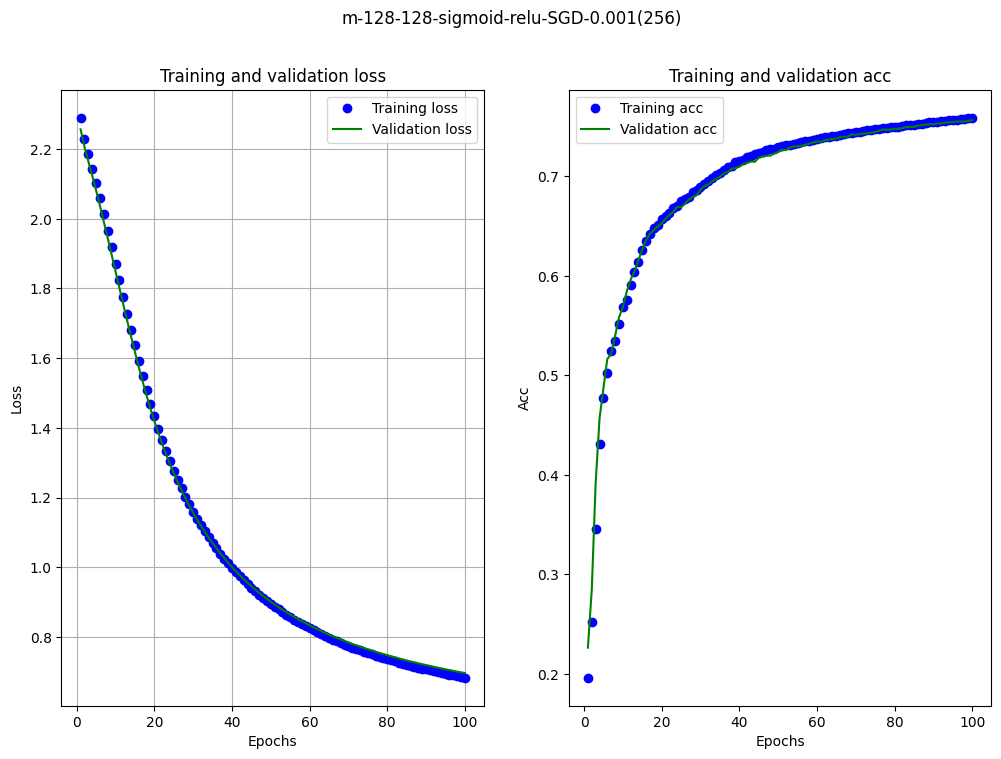

In [23]:
retest_NN(
          set_layers=[NUM_FEATURES, 128, 128, NUM_CLASSES], 
          act=['sigmoid', 'relu', 'softmax'], 
          opt=optimizers.legacy.SGD, 
          lr=0.001,
          bs=256,
          )

майже без змін за попередній, змінюватимемо інші параметри....

Epoch 1/100
235/235 [==============================] - 1s 3ms/step - loss: 0.8321 - accuracy: 0.7413 - val_loss: 0.5254 - val_accuracy: 0.8117
Epoch 2/100
235/235 [==============================] - 1s 3ms/step - loss: 0.4617 - accuracy: 0.8354 - val_loss: 0.4554 - val_accuracy: 0.8376
Epoch 3/100
235/235 [==============================] - 1s 3ms/step - loss: 0.4082 - accuracy: 0.8544 - val_loss: 0.4245 - val_accuracy: 0.8459
Epoch 4/100
235/235 [==============================] - 1s 3ms/step - loss: 0.3834 - accuracy: 0.8615 - val_loss: 0.4171 - val_accuracy: 0.8483
Epoch 5/100
235/235 [==============================] - 1s 3ms/step - loss: 0.3648 - accuracy: 0.8678 - val_loss: 0.3972 - val_accuracy: 0.8578
Epoch 6/100
235/235 [==============================] - 1s 3ms/step - loss: 0.3506 - accuracy: 0.8730 - val_loss: 0.3930 - val_accuracy: 0.8579
Epoch 7/100
235/235 [==============================] - 1s 3ms/step - loss: 0.3390 - accuracy: 0.8765 - val_loss: 0.3775 - val_accuracy: 0.8647

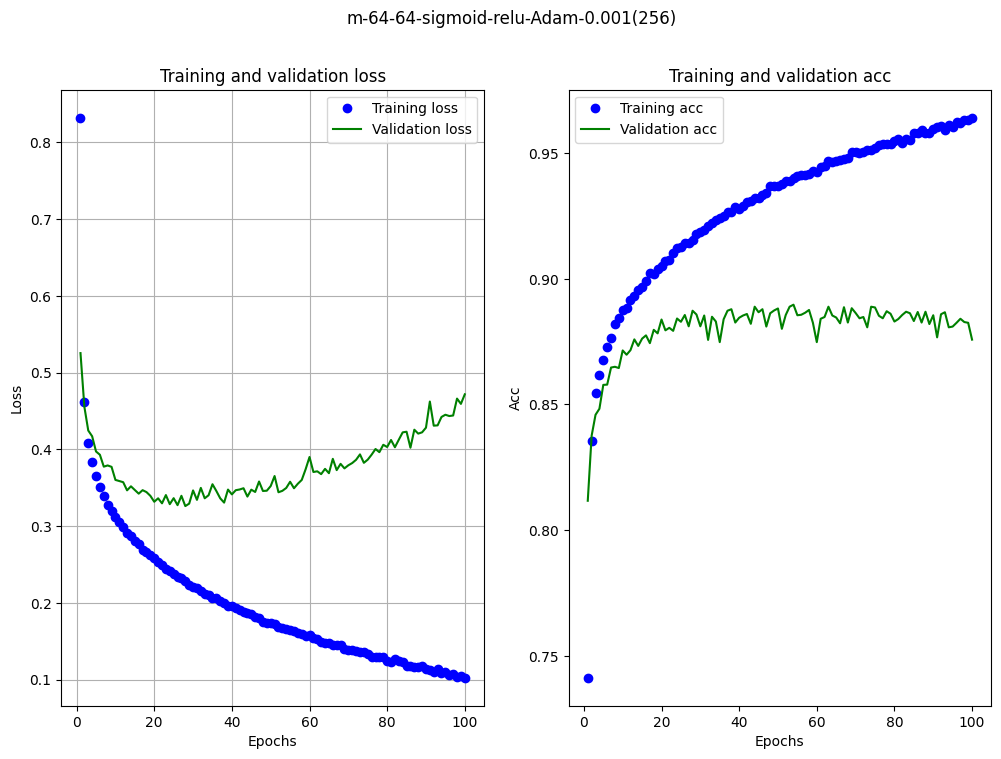

In [24]:
retest_NN(
          set_layers=[NUM_FEATURES, 64, 64, NUM_CLASSES], 
          act=['sigmoid', 'relu', 'softmax'], 
          opt=optimizers.legacy.Adam, 
          lr=0.001,
          bs=256,
          )

явне перенавчання з орієнтовно 25ї епохи

Epoch 1/100
235/235 [==============================] - 1s 3ms/step - loss: 0.8007 - accuracy: 0.7479 - val_loss: 0.5541 - val_accuracy: 0.7959
Epoch 2/100
235/235 [==============================] - 1s 3ms/step - loss: 0.4678 - accuracy: 0.8319 - val_loss: 0.5033 - val_accuracy: 0.8177
Epoch 3/100
235/235 [==============================] - 1s 4ms/step - loss: 0.4212 - accuracy: 0.8467 - val_loss: 0.4780 - val_accuracy: 0.8223
Epoch 4/100
235/235 [==============================] - 1s 3ms/step - loss: 0.3942 - accuracy: 0.8584 - val_loss: 0.4261 - val_accuracy: 0.8462
Epoch 5/100
235/235 [==============================] - 1s 3ms/step - loss: 0.3767 - accuracy: 0.8632 - val_loss: 0.4006 - val_accuracy: 0.8536
Epoch 6/100
235/235 [==============================] - 1s 3ms/step - loss: 0.3630 - accuracy: 0.8678 - val_loss: 0.3927 - val_accuracy: 0.8611
Epoch 7/100
235/235 [==============================] - 1s 3ms/step - loss: 0.3500 - accuracy: 0.8720 - val_loss: 0.4164 - val_accuracy: 0.8511

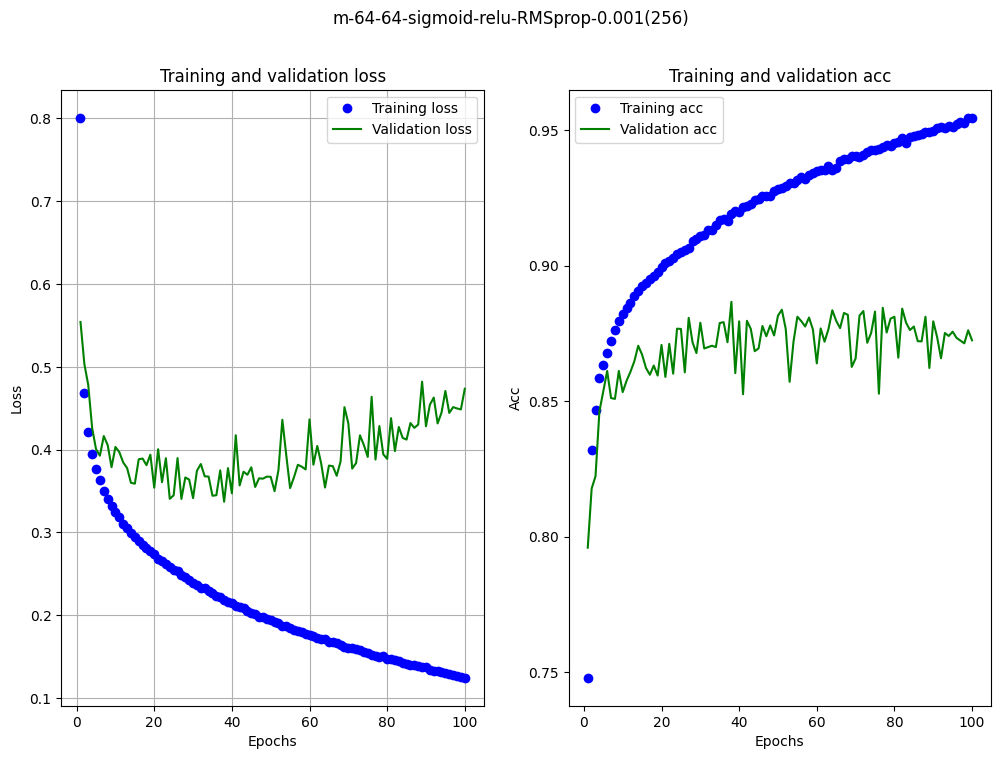

In [25]:
retest_NN(
          set_layers=[NUM_FEATURES, 64, 64, NUM_CLASSES], 
          act=['sigmoid', 'relu', 'softmax'], 
          opt=optimizers.legacy.RMSprop, 
          lr=0.001,
          bs=256,
          )

майже так само, так само точність валідаційно не перевищує 0.9

Epoch 1/100
235/235 [==============================] - 1s 3ms/step - loss: 0.5554 - accuracy: 0.8001 - val_loss: 0.4383 - val_accuracy: 0.8419
Epoch 2/100
235/235 [==============================] - 1s 3ms/step - loss: 0.3830 - accuracy: 0.8592 - val_loss: 0.3872 - val_accuracy: 0.8586
Epoch 3/100
235/235 [==============================] - 1s 3ms/step - loss: 0.3534 - accuracy: 0.8702 - val_loss: 0.3784 - val_accuracy: 0.8621
Epoch 4/100
235/235 [==============================] - 1s 3ms/step - loss: 0.3295 - accuracy: 0.8798 - val_loss: 0.3914 - val_accuracy: 0.8513
Epoch 5/100
235/235 [==============================] - 1s 3ms/step - loss: 0.3182 - accuracy: 0.8837 - val_loss: 0.4088 - val_accuracy: 0.8579
Epoch 6/100
235/235 [==============================] - 1s 3ms/step - loss: 0.3090 - accuracy: 0.8852 - val_loss: 0.3571 - val_accuracy: 0.8712
Epoch 7/100
235/235 [==============================] - 1s 3ms/step - loss: 0.3019 - accuracy: 0.8892 - val_loss: 0.3664 - val_accuracy: 0.8676

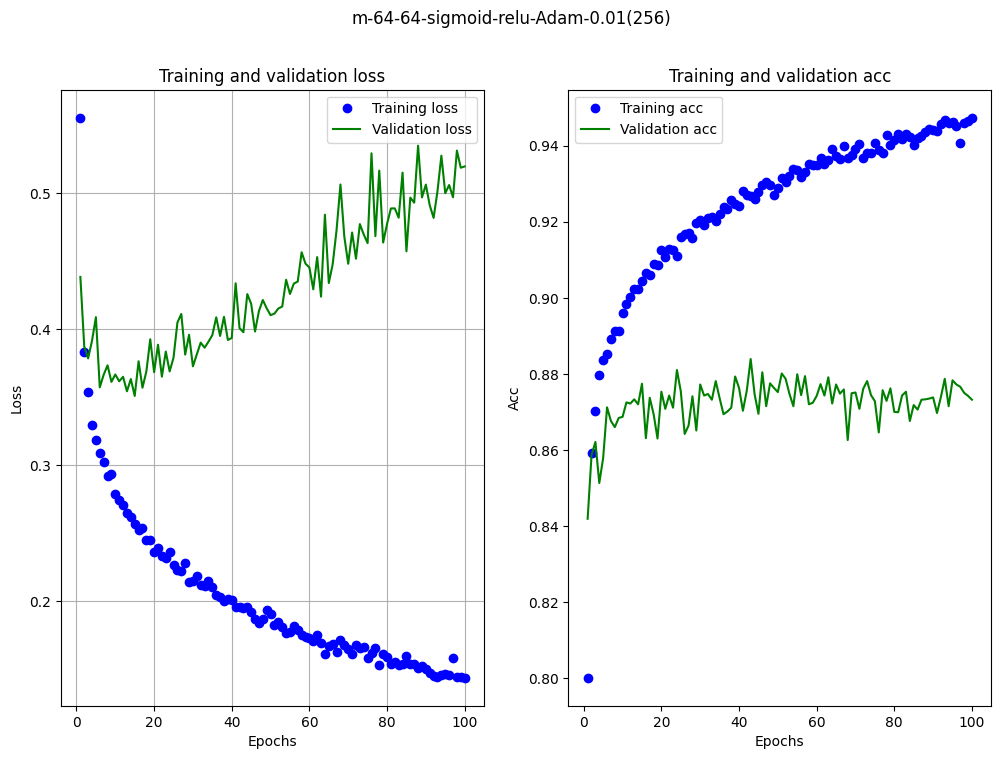

In [26]:
retest_NN(
          set_layers=[NUM_FEATURES, 64, 64, NUM_CLASSES], 
          act=['sigmoid', 'relu', 'softmax'], 
          opt=optimizers.legacy.Adam, 
          lr=0.01,
          bs=256,
          )

перенавчання з 18ї епохи...

Epoch 1/100
235/235 [==============================] - 1s 3ms/step - loss: 1.8387 - accuracy: 0.4936 - val_loss: 1.4340 - val_accuracy: 0.6109
Epoch 2/100
235/235 [==============================] - 1s 3ms/step - loss: 1.1855 - accuracy: 0.6773 - val_loss: 1.0090 - val_accuracy: 0.7091
Epoch 3/100
235/235 [==============================] - 1s 3ms/step - loss: 0.8880 - accuracy: 0.7397 - val_loss: 0.8120 - val_accuracy: 0.7417
Epoch 4/100
235/235 [==============================] - 1s 3ms/step - loss: 0.7362 - accuracy: 0.7672 - val_loss: 0.7030 - val_accuracy: 0.7686
Epoch 5/100
235/235 [==============================] - 1s 3ms/step - loss: 0.6515 - accuracy: 0.7860 - val_loss: 0.6402 - val_accuracy: 0.7829
Epoch 6/100
235/235 [==============================] - 1s 3ms/step - loss: 0.5975 - accuracy: 0.8008 - val_loss: 0.5965 - val_accuracy: 0.7950
Epoch 7/100
235/235 [==============================] - 1s 3ms/step - loss: 0.5588 - accuracy: 0.8107 - val_loss: 0.5638 - val_accuracy: 0.8066

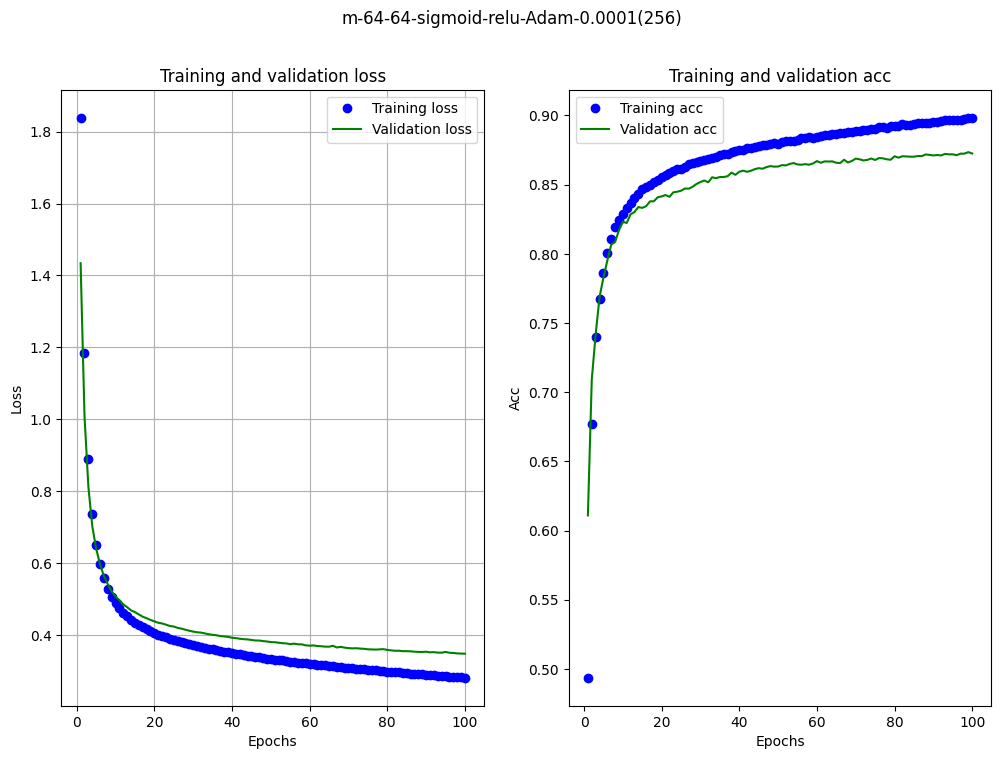

In [27]:
retest_NN(
          set_layers=[NUM_FEATURES, 64, 64, NUM_CLASSES], 
          act=['sigmoid', 'relu', 'softmax'], 
          opt=optimizers.legacy.Adam, 
          lr=0.0001,
          bs=256,
          )

Epoch 1/100
469/469 [==============================] - 1s 2ms/step - loss: 0.7114 - accuracy: 0.7659 - val_loss: 0.5049 - val_accuracy: 0.8189
Epoch 2/100
469/469 [==============================] - 1s 2ms/step - loss: 0.4265 - accuracy: 0.8477 - val_loss: 0.4320 - val_accuracy: 0.8450
Epoch 3/100
469/469 [==============================] - 1s 2ms/step - loss: 0.3872 - accuracy: 0.8609 - val_loss: 0.4037 - val_accuracy: 0.8557
Epoch 4/100
469/469 [==============================] - 1s 2ms/step - loss: 0.3604 - accuracy: 0.8691 - val_loss: 0.3871 - val_accuracy: 0.8633
Epoch 5/100
469/469 [==============================] - 1s 2ms/step - loss: 0.3466 - accuracy: 0.8742 - val_loss: 0.3757 - val_accuracy: 0.8662
Epoch 6/100
469/469 [==============================] - 1s 2ms/step - loss: 0.3320 - accuracy: 0.8789 - val_loss: 0.3738 - val_accuracy: 0.8659
Epoch 7/100
469/469 [==============================] - 1s 2ms/step - loss: 0.3194 - accuracy: 0.8840 - val_loss: 0.3722 - val_accuracy: 0.8662

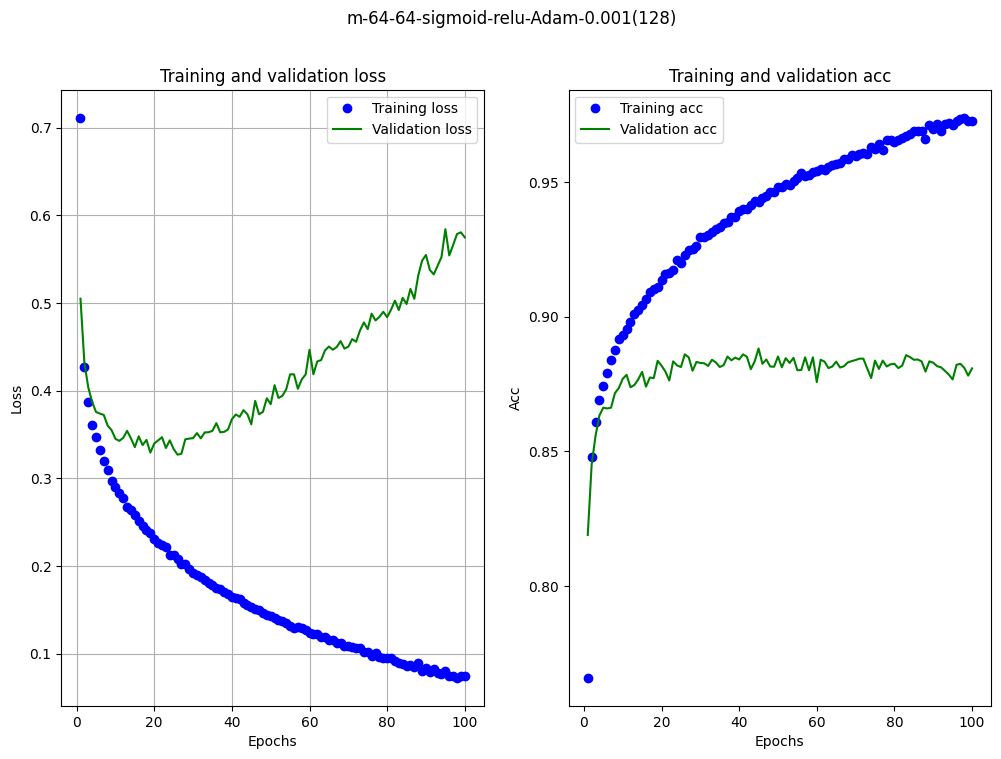

In [28]:
retest_NN(
          set_layers=[NUM_FEATURES, 64, 64, NUM_CLASSES], 
          act=['sigmoid', 'relu', 'softmax'], 
          opt=optimizers.legacy.Adam, 
          lr=0.001,
          bs=128,
          )

Epoch 1/100
118/118 [==============================] - 1s 4ms/step - loss: 1.1504 - accuracy: 0.6489 - val_loss: 0.6651 - val_accuracy: 0.7642
Epoch 2/100
118/118 [==============================] - 0s 3ms/step - loss: 0.5598 - accuracy: 0.8045 - val_loss: 0.5269 - val_accuracy: 0.8124
Epoch 3/100
118/118 [==============================] - 0s 3ms/step - loss: 0.4698 - accuracy: 0.8333 - val_loss: 0.4738 - val_accuracy: 0.8302
Epoch 4/100
118/118 [==============================] - 0s 3ms/step - loss: 0.4252 - accuracy: 0.8487 - val_loss: 0.4404 - val_accuracy: 0.8400
Epoch 5/100
118/118 [==============================] - 0s 3ms/step - loss: 0.4018 - accuracy: 0.8564 - val_loss: 0.4302 - val_accuracy: 0.8457
Epoch 6/100
118/118 [==============================] - 0s 3ms/step - loss: 0.3831 - accuracy: 0.8629 - val_loss: 0.4148 - val_accuracy: 0.8505
Epoch 7/100
118/118 [==============================] - 0s 3ms/step - loss: 0.3696 - accuracy: 0.8674 - val_loss: 0.4005 - val_accuracy: 0.8568

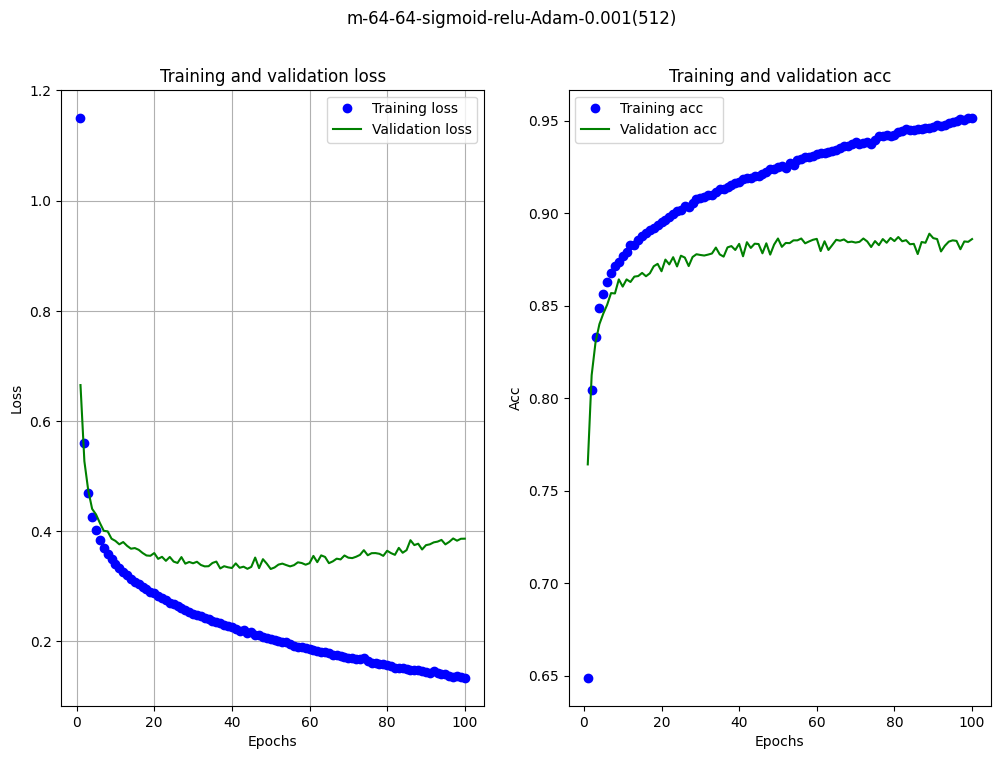

In [29]:
retest_NN(
          set_layers=[NUM_FEATURES, 64, 64, NUM_CLASSES], 
          act=['sigmoid', 'relu', 'softmax'], 
          opt=optimizers.legacy.Adam, 
          lr=0.001,
          bs=512,
          )

Epoch 1/100
118/118 [==============================] - 1s 5ms/step - loss: 0.9192 - accuracy: 0.7119 - val_loss: 0.5704 - val_accuracy: 0.7941
Epoch 2/100
118/118 [==============================] - 1s 5ms/step - loss: 0.4880 - accuracy: 0.8248 - val_loss: 0.4729 - val_accuracy: 0.8309
Epoch 3/100
118/118 [==============================] - 1s 5ms/step - loss: 0.4285 - accuracy: 0.8454 - val_loss: 0.4509 - val_accuracy: 0.8355
Epoch 4/100
118/118 [==============================] - 1s 5ms/step - loss: 0.4004 - accuracy: 0.8569 - val_loss: 0.4227 - val_accuracy: 0.8488
Epoch 5/100
118/118 [==============================] - 1s 5ms/step - loss: 0.3801 - accuracy: 0.8639 - val_loss: 0.4074 - val_accuracy: 0.8529
Epoch 6/100
118/118 [==============================] - 1s 5ms/step - loss: 0.3654 - accuracy: 0.8682 - val_loss: 0.4002 - val_accuracy: 0.8557
Epoch 7/100
118/118 [==============================] - 1s 5ms/step - loss: 0.3519 - accuracy: 0.8728 - val_loss: 0.3971 - val_accuracy: 0.8577

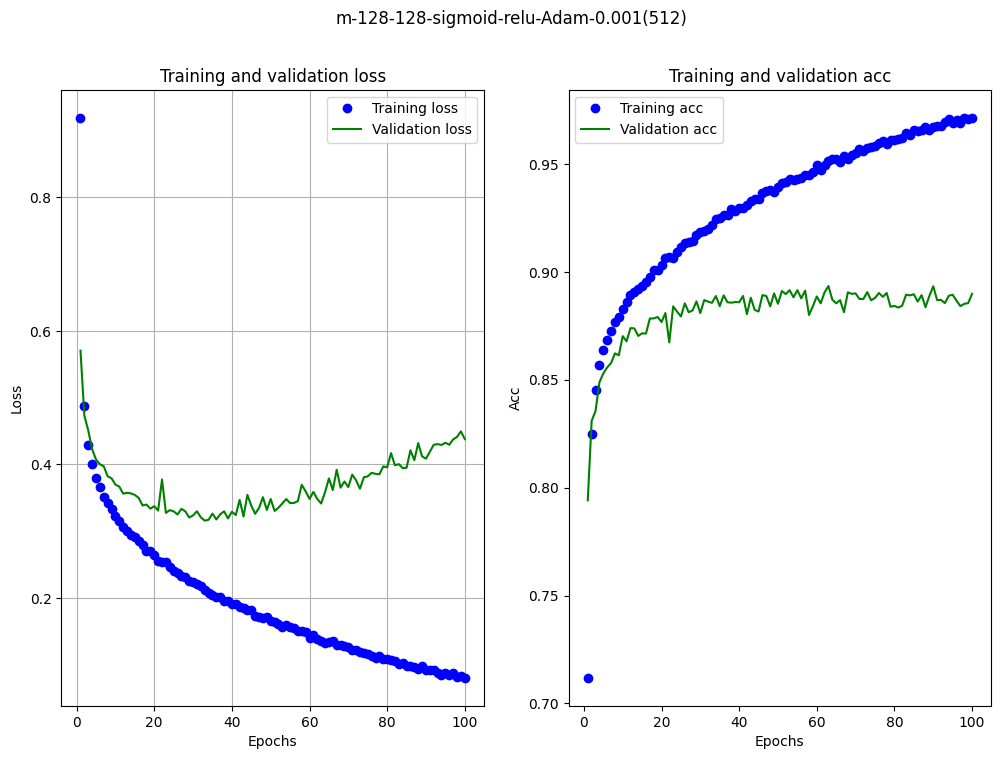

In [33]:
retest_NN(
          set_layers=[NUM_FEATURES, 128, 128, NUM_CLASSES], 
          act=['sigmoid', 'relu', 'softmax'], 
          opt=optimizers.legacy.Adam, 
          lr=0.001,
          bs=512,
          )

Epoch 1/100
118/118 [==============================] - 1s 6ms/step - loss: 0.6584 - accuracy: 0.7761 - val_loss: 0.4823 - val_accuracy: 0.8279
Epoch 2/100
118/118 [==============================] - 1s 5ms/step - loss: 0.4330 - accuracy: 0.8471 - val_loss: 0.4624 - val_accuracy: 0.8323
Epoch 3/100
118/118 [==============================] - 1s 5ms/step - loss: 0.3908 - accuracy: 0.8595 - val_loss: 0.4257 - val_accuracy: 0.8507
Epoch 4/100
118/118 [==============================] - 1s 5ms/step - loss: 0.3579 - accuracy: 0.8716 - val_loss: 0.3893 - val_accuracy: 0.8611
Epoch 5/100
118/118 [==============================] - 1s 5ms/step - loss: 0.3400 - accuracy: 0.8774 - val_loss: 0.3819 - val_accuracy: 0.8615
Epoch 6/100
118/118 [==============================] - 1s 5ms/step - loss: 0.3235 - accuracy: 0.8824 - val_loss: 0.3567 - val_accuracy: 0.8701
Epoch 7/100
118/118 [==============================] - 1s 5ms/step - loss: 0.3126 - accuracy: 0.8850 - val_loss: 0.3656 - val_accuracy: 0.8664

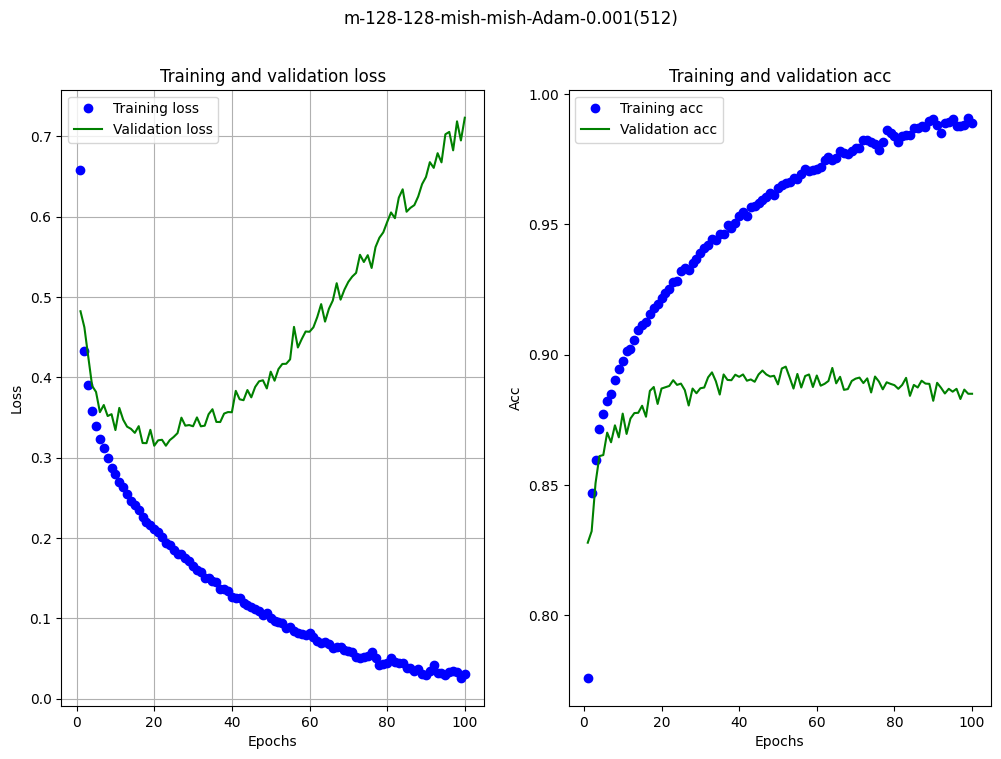

In [37]:
retest_NN(
          set_layers=[NUM_FEATURES, 128, 128, NUM_CLASSES], 
          act=['mish', 'mish', 'softmax'], 
          opt=optimizers.legacy.Adam, 
          lr=0.001,
          bs=512,
          )

Варіант 1:

Epoch 1/100
469/469 [==============================] - 3s 5ms/step - loss: 0.5232 - accuracy: 0.8133 - val_loss: 0.4098 - val_accuracy: 0.8513
Epoch 2/100
469/469 [==============================] - 2s 5ms/step - loss: 0.3627 - accuracy: 0.8682 - val_loss: 0.3845 - val_accuracy: 0.8571
Epoch 3/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3215 - accuracy: 0.8816 - val_loss: 0.3694 - val_accuracy: 0.8629
Epoch 4/100
469/469 [==============================] - 2s 5ms/step - loss: 0.2960 - accuracy: 0.8892 - val_loss: 0.3526 - val_accuracy: 0.8696
Epoch 5/100
469/469 [==============================] - 2s 5ms/step - loss: 0.2778 - accuracy: 0.8963 - val_loss: 0.3320 - val_accuracy: 0.8827
Epoch 6/100
469/469 [==============================] - 3s 5ms/step - loss: 0.2643 - accuracy: 0.9005 - val_loss: 0.3388 - val_accuracy: 0.8795
Epoch 7/100
469/469 [==============================] - 2s 5ms/step - loss: 0.2477 - accuracy: 0.9076 - val_loss: 0.3174 - val_accuracy: 0.8871

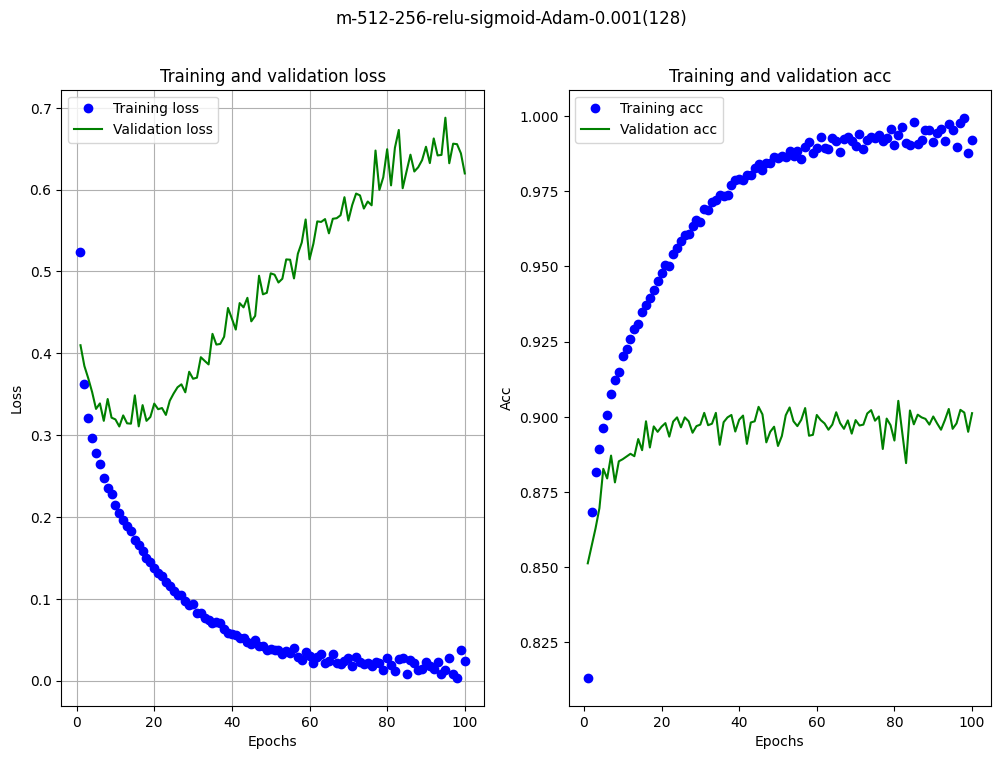

In [55]:
retest_NN(
          set_layers=[NUM_FEATURES, 512, 256, NUM_CLASSES], 
          act=['relu', 'sigmoid', 'softmax'], 
          opt=optimizers.legacy.Adam, 
          lr=0.001,
          bs=128,
          )

Epoch 1/100
30/30 [==============================] - 1s 29ms/step - loss: 9.0066 - accuracy: 0.1001 - val_loss: 4.8159 - val_accuracy: 0.1000
Epoch 2/100
30/30 [==============================] - 1s 25ms/step - loss: 2.5616 - accuracy: 0.1764 - val_loss: 1.9334 - val_accuracy: 0.2094
Epoch 3/100
30/30 [==============================] - 1s 25ms/step - loss: 1.8265 - accuracy: 0.2173 - val_loss: 1.6967 - val_accuracy: 0.2701
Epoch 4/100
30/30 [==============================] - 1s 25ms/step - loss: 1.5693 - accuracy: 0.3140 - val_loss: 1.6045 - val_accuracy: 0.3067
Epoch 5/100
30/30 [==============================] - 1s 25ms/step - loss: 1.4986 - accuracy: 0.3377 - val_loss: 1.5136 - val_accuracy: 0.3295
Epoch 6/100
30/30 [==============================] - 1s 25ms/step - loss: 1.8679 - accuracy: 0.2539 - val_loss: 1.7219 - val_accuracy: 0.3359
Epoch 7/100
30/30 [==============================] - 1s 26ms/step - loss: 1.6222 - accuracy: 0.3040 - val_loss: 1.8564 - val_accuracy: 0.2683
Epoch 

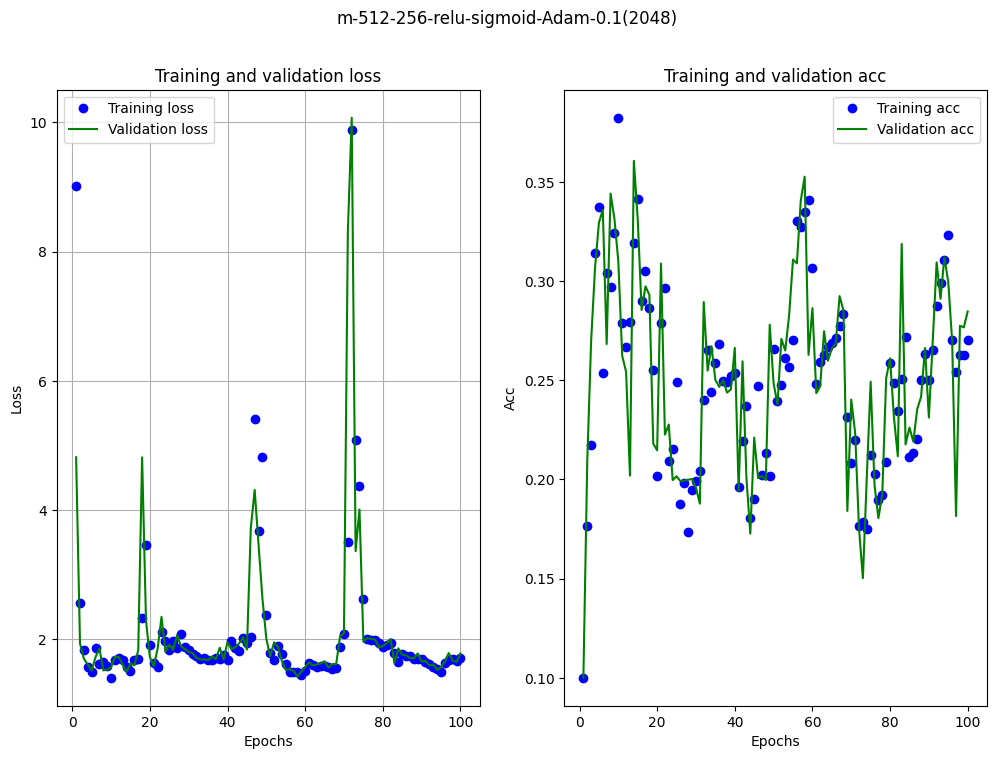

In [61]:
retest_NN(
          set_layers=[NUM_FEATURES, 512, 256, NUM_CLASSES], 
          act=['relu', 'sigmoid', 'softmax'], 
          opt=optimizers.legacy.Adam, 
          lr=0.1,
          bs=2048,
          )

Варіант 2:

Epoch 1/100
118/118 [==============================] - 2s 12ms/step - loss: 0.6545 - accuracy: 0.7818 - val_loss: 0.5123 - val_accuracy: 0.8198
Epoch 2/100
118/118 [==============================] - 1s 11ms/step - loss: 0.4375 - accuracy: 0.8486 - val_loss: 0.4409 - val_accuracy: 0.8448
Epoch 3/100
118/118 [==============================] - 2s 14ms/step - loss: 0.3977 - accuracy: 0.8611 - val_loss: 0.4195 - val_accuracy: 0.8510
Epoch 4/100
118/118 [==============================] - 1s 10ms/step - loss: 0.3708 - accuracy: 0.8691 - val_loss: 0.4101 - val_accuracy: 0.8550
Epoch 5/100
118/118 [==============================] - 1s 13ms/step - loss: 0.3546 - accuracy: 0.8751 - val_loss: 0.3955 - val_accuracy: 0.8590
Epoch 6/100
118/118 [==============================] - 1s 10ms/step - loss: 0.3365 - accuracy: 0.8808 - val_loss: 0.3938 - val_accuracy: 0.8576
Epoch 7/100
118/118 [==============================] - 1s 10ms/step - loss: 0.3212 - accuracy: 0.8861 - val_loss: 0.3693 - val_accuracy:

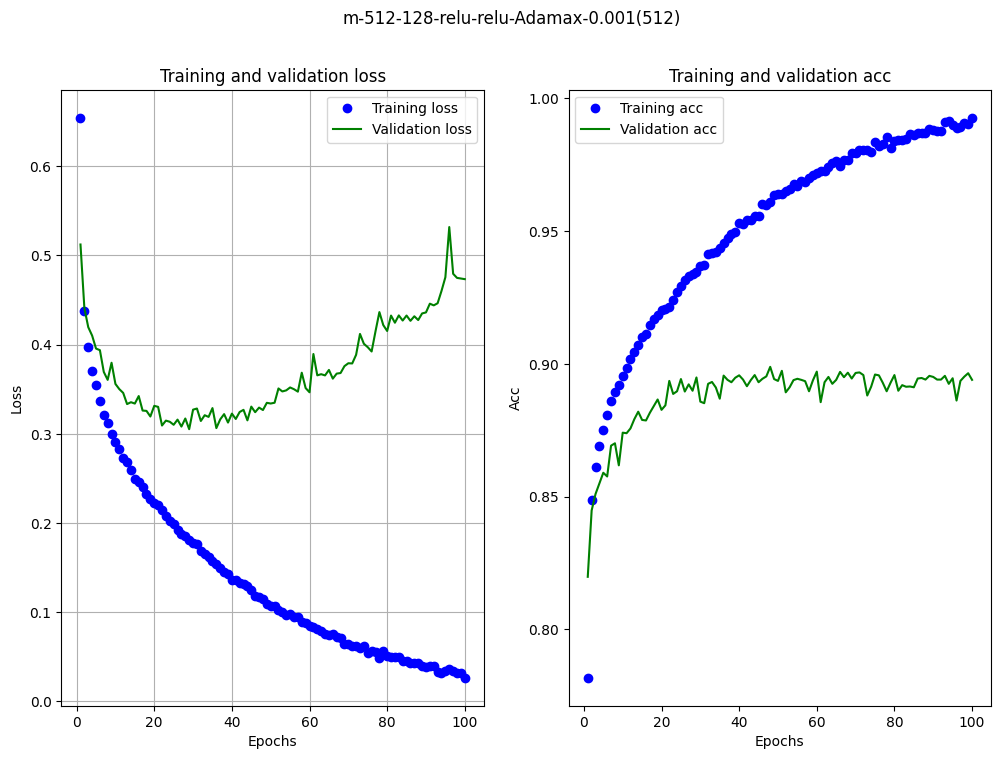

In [64]:
retest_NN(
          set_layers=[NUM_FEATURES, 512, 128, NUM_CLASSES], 
          act=['relu', 'relu', 'softmax'], 
          opt=optimizers.legacy.Adamax, 
          lr=0.001,
          bs=512,
          )

Epoch 1/100
30/30 [==============================] - 2s 50ms/step - loss: 2.2757 - accuracy: 0.2052 - val_loss: 2.2092 - val_accuracy: 0.3129
Epoch 2/100
30/30 [==============================] - 1s 45ms/step - loss: 2.1611 - accuracy: 0.4077 - val_loss: 2.1069 - val_accuracy: 0.4982
Epoch 3/100
30/30 [==============================] - 1s 46ms/step - loss: 2.0585 - accuracy: 0.5366 - val_loss: 2.0043 - val_accuracy: 0.5535
Epoch 4/100
30/30 [==============================] - 1s 49ms/step - loss: 1.9536 - accuracy: 0.5835 - val_loss: 1.8983 - val_accuracy: 0.5829
Epoch 5/100
30/30 [==============================] - 1s 47ms/step - loss: 1.8465 - accuracy: 0.6041 - val_loss: 1.7909 - val_accuracy: 0.6081
Epoch 6/100
30/30 [==============================] - 1s 48ms/step - loss: 1.7392 - accuracy: 0.6208 - val_loss: 1.6863 - val_accuracy: 0.6188
Epoch 7/100
30/30 [==============================] - 1s 45ms/step - loss: 1.6360 - accuracy: 0.6343 - val_loss: 1.5864 - val_accuracy: 0.6432
Epoch 

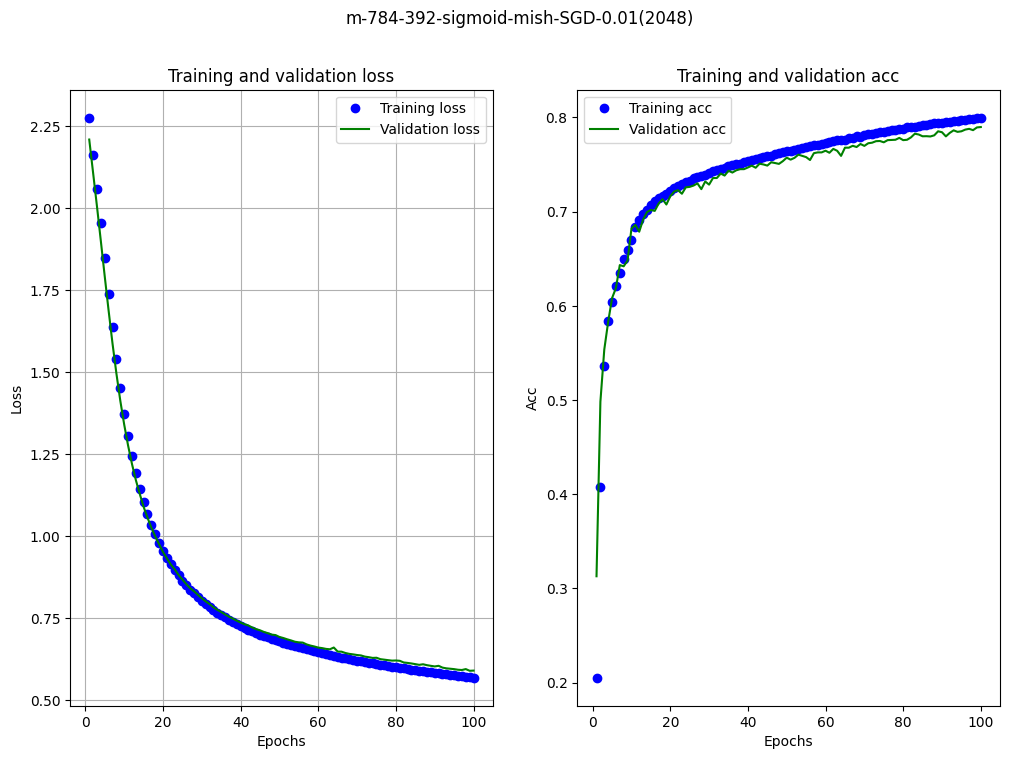

In [93]:
retest_NN(
          set_layers=[NUM_FEATURES, 784, 392, NUM_CLASSES], 
          act=['sigmoid', 'mish', 'softmax'], 
          opt=optimizers.legacy.SGD, 
          lr=0.01,
          bs=2048,
          )

Варіант 3:

Epoch 1/100
235/235 [==============================] - 3s 12ms/step - loss: 0.9481 - accuracy: 0.7576 - val_loss: 0.6326 - val_accuracy: 0.8269
Epoch 2/100
235/235 [==============================] - 3s 11ms/step - loss: 0.5103 - accuracy: 0.8503 - val_loss: 0.4907 - val_accuracy: 0.8394
Epoch 3/100
235/235 [==============================] - 2s 10ms/step - loss: 0.4059 - accuracy: 0.8696 - val_loss: 0.4058 - val_accuracy: 0.8661
Epoch 4/100
235/235 [==============================] - 3s 11ms/step - loss: 0.3553 - accuracy: 0.8807 - val_loss: 0.3776 - val_accuracy: 0.8703
Epoch 5/100
235/235 [==============================] - 2s 10ms/step - loss: 0.3252 - accuracy: 0.8876 - val_loss: 0.3658 - val_accuracy: 0.8705
Epoch 6/100
235/235 [==============================] - 3s 11ms/step - loss: 0.3021 - accuracy: 0.8942 - val_loss: 0.3652 - val_accuracy: 0.8709
Epoch 7/100
235/235 [==============================] - 2s 10ms/step - loss: 0.2861 - accuracy: 0.8982 - val_loss: 0.3471 - val_accuracy:

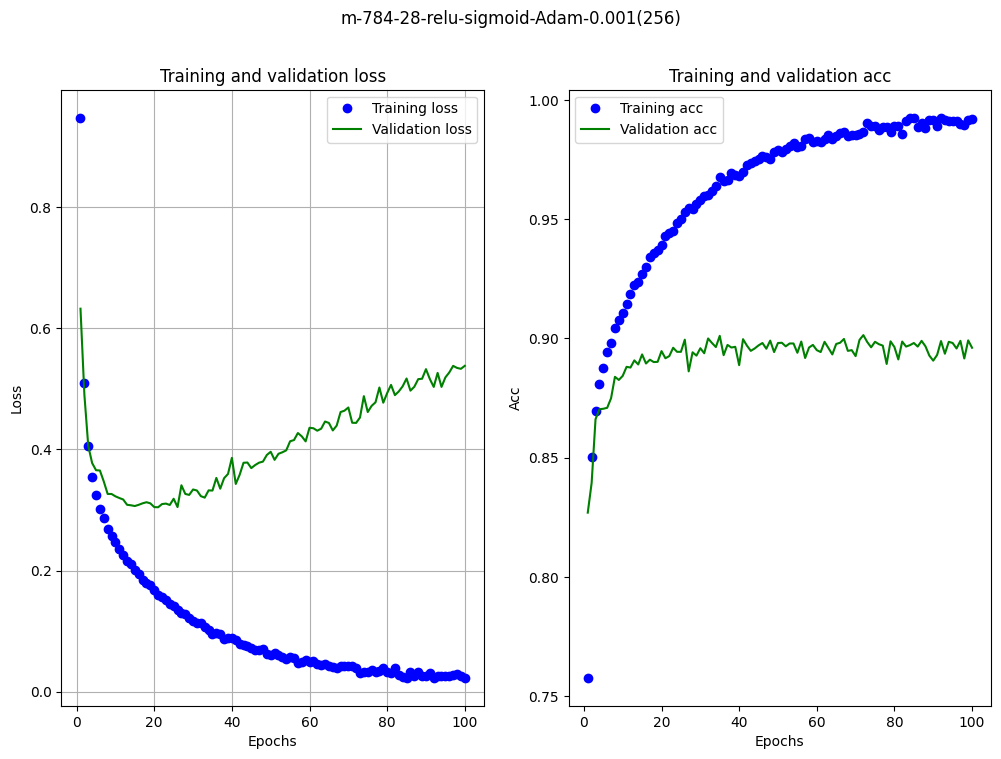

In [66]:
retest_NN(
          set_layers=[NUM_FEATURES, 784, 28, NUM_CLASSES], 
          act=['relu', 'sigmoid', 'softmax'], 
          opt=optimizers.legacy.Adam, 
          lr=0.001,
          bs=256,
          )

Варіант 4:

Epoch 1/100
118/118 [==============================] - 2s 15ms/step - loss: 0.6619 - accuracy: 0.7758 - val_loss: 0.4691 - val_accuracy: 0.8322
Epoch 2/100
118/118 [==============================] - 2s 14ms/step - loss: 0.4135 - accuracy: 0.8511 - val_loss: 0.4214 - val_accuracy: 0.8510
Epoch 3/100
118/118 [==============================] - 2s 14ms/step - loss: 0.3672 - accuracy: 0.8680 - val_loss: 0.3934 - val_accuracy: 0.8609
Epoch 4/100
118/118 [==============================] - 1s 12ms/step - loss: 0.3473 - accuracy: 0.8744 - val_loss: 0.3824 - val_accuracy: 0.8619
Epoch 5/100
118/118 [==============================] - 1s 13ms/step - loss: 0.3180 - accuracy: 0.8852 - val_loss: 0.3596 - val_accuracy: 0.8700
Epoch 6/100
118/118 [==============================] - 2s 13ms/step - loss: 0.3028 - accuracy: 0.8886 - val_loss: 0.3486 - val_accuracy: 0.8724
Epoch 7/100
118/118 [==============================] - 2s 15ms/step - loss: 0.2865 - accuracy: 0.8952 - val_loss: 0.3434 - val_accuracy:

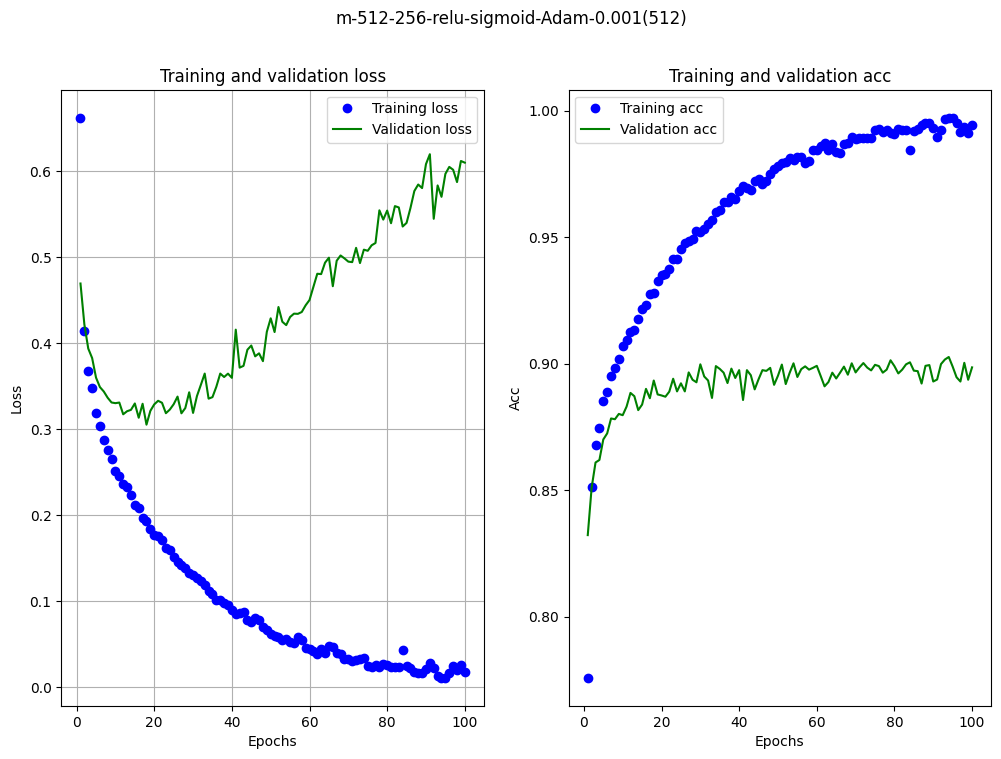

In [53]:
retest_NN(
          set_layers=[NUM_FEATURES, 512, 256, NUM_CLASSES], 
          act=['relu', 'sigmoid', 'softmax'], 
          opt=optimizers.legacy.Adam, 
          lr=0.001,
          bs=512,
          )

Варіант 5:

Epoch 1/100
469/469 [==============================] - 3s 6ms/step - loss: 0.5175 - accuracy: 0.8172 - val_loss: 0.4436 - val_accuracy: 0.8414
Epoch 2/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3608 - accuracy: 0.8678 - val_loss: 0.3721 - val_accuracy: 0.8652
Epoch 3/100
469/469 [==============================] - 2s 5ms/step - loss: 0.3223 - accuracy: 0.8826 - val_loss: 0.3611 - val_accuracy: 0.8700
Epoch 4/100
469/469 [==============================] - 2s 5ms/step - loss: 0.2979 - accuracy: 0.8901 - val_loss: 0.3421 - val_accuracy: 0.8757
Epoch 5/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2787 - accuracy: 0.8967 - val_loss: 0.3241 - val_accuracy: 0.8834
Epoch 6/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2643 - accuracy: 0.9023 - val_loss: 0.3173 - val_accuracy: 0.8867
Epoch 7/100
469/469 [==============================] - 2s 5ms/step - loss: 0.2493 - accuracy: 0.9075 - val_loss: 0.3475 - val_accuracy: 0.8710

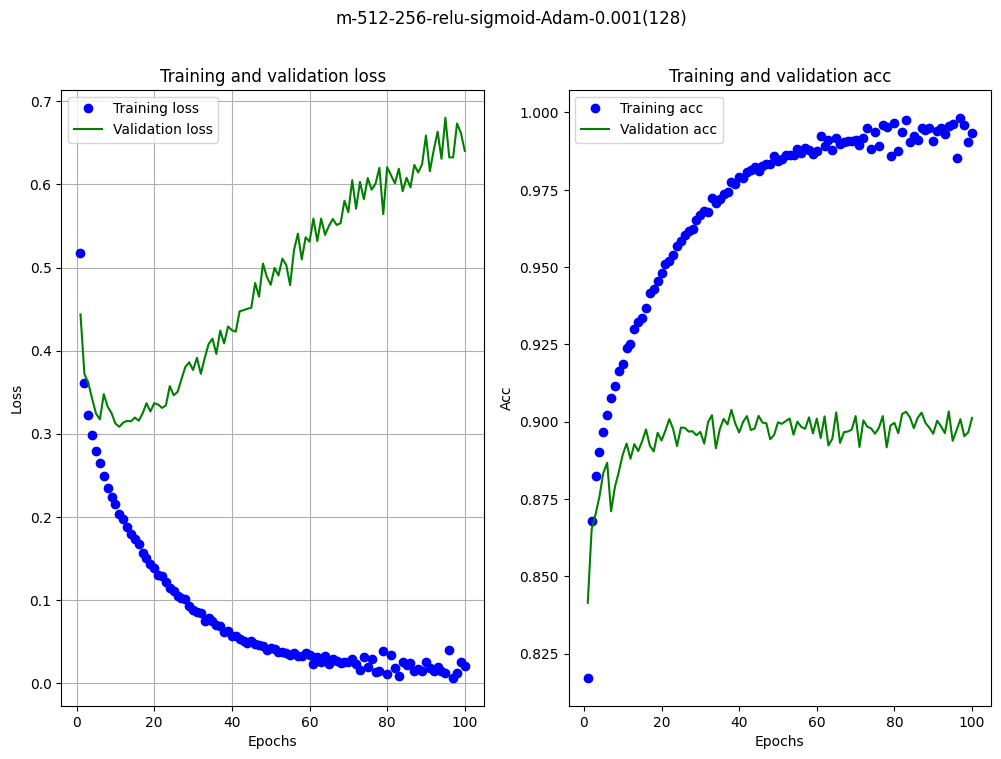

In [63]:
retest_NN(
          set_layers=[NUM_FEATURES, 512, 256, NUM_CLASSES], 
          act=['relu', 'sigmoid', 'softmax'], 
          opt=optimizers.legacy.Adam, 
          lr=0.001,
          bs=128,
          )

Epoch 1/36
118/118 [==============================] - 9s 77ms/step - loss: 0.5618 - accuracy: 0.8046 - val_loss: 0.4352 - val_accuracy: 0.8463
Epoch 2/36
118/118 [==============================] - 9s 75ms/step - loss: 0.3672 - accuracy: 0.8684 - val_loss: 0.3922 - val_accuracy: 0.8610
Epoch 3/36
118/118 [==============================] - 9s 76ms/step - loss: 0.3290 - accuracy: 0.8803 - val_loss: 0.3678 - val_accuracy: 0.8666
Epoch 4/36
118/118 [==============================] - 9s 76ms/step - loss: 0.3006 - accuracy: 0.8905 - val_loss: 0.3550 - val_accuracy: 0.8690
Epoch 5/36
118/118 [==============================] - 9s 76ms/step - loss: 0.2810 - accuracy: 0.8982 - val_loss: 0.3465 - val_accuracy: 0.8742
Epoch 6/36
118/118 [==============================] - 9s 76ms/step - loss: 0.2655 - accuracy: 0.9030 - val_loss: 0.3215 - val_accuracy: 0.8811
Epoch 7/36
118/118 [==============================] - 9s 76ms/step - loss: 0.2503 - accuracy: 0.9078 - val_loss: 0.3406 - val_accuracy: 0.8797

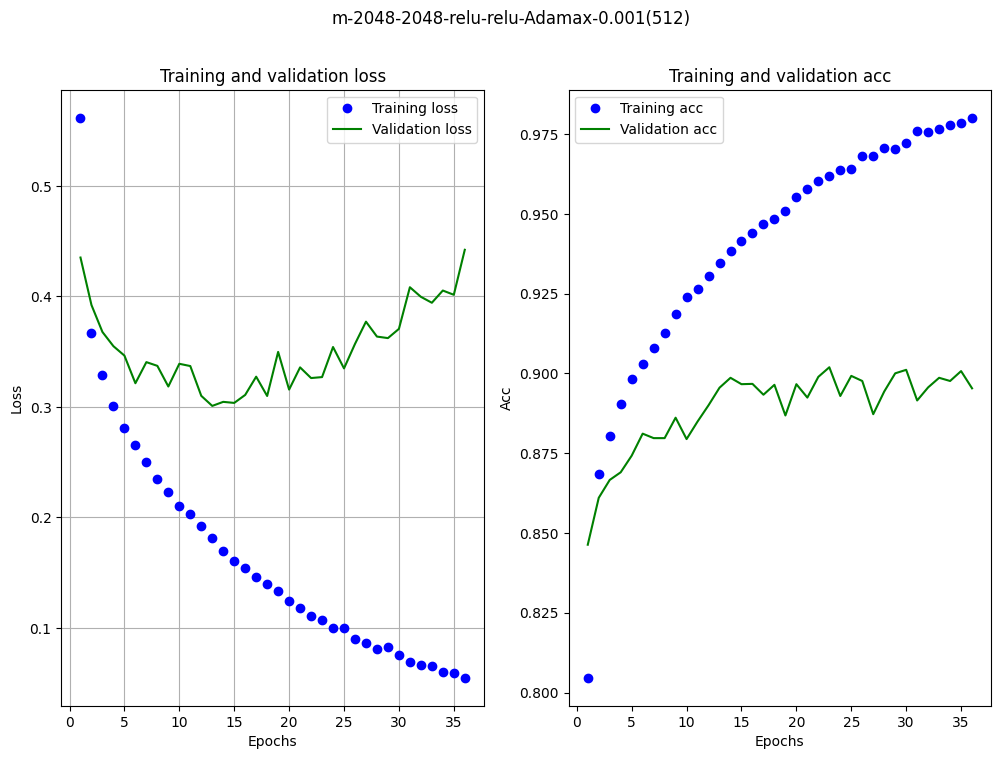

In [115]:
retest_NN(
          set_layers=[NUM_FEATURES, 2048, 2048, NUM_CLASSES], 
          act=['relu', 'relu', 'softmax'], 
          opt=optimizers.legacy.Adamax, 
          lr=0.001,
          bs=512,
          epochs=36
          )

### __result__

Найкращі варіанти з перевірених: <br>
- relu-512 sigmoid-256 Adam 128 lr=0.001 = Epoch 16: 3s 6ms/step - loss: 0.1660 - accuracy: 0.9370 - val_loss: 0.3107 - val_accuracy: 0.8985
- relu-512 relu-128 Adamax 512 lr=0.001 = Epoch 29: 1s 12ms/step - loss: 0.1804 - accuracy: 0.9347 - val_loss: 0.3051 - val_accuracy: 0.8949
- relu-784 sigmoid-28 Adam 256 lr=0.001 = Epoch 26: 3s 12ms/step - loss: 0.1346 - accuracy: 0.9530 - val_loss: 0.3048 - val_accuracy: 0.8995
- relu-512 sigmoid-256 Adam 512 lr=0.001 =Epoch 18: 1s 13ms/step - loss: 0.1930 - accuracy: 0.9281 - val_loss: 0.3049 - val_accuracy: 0.8933
- relu-512 sigmoid-256 Adam 128 lr=0.001 = Epoch 11: 2s 5ms/step - loss: 0.2037 - accuracy: 0.9238 - val_loss: 0.3083 - val_accuracy: 0.8929
'Валідаційна' точність в деяких випадках була і більшою за 0.9 але незначно і на проміжках перенавчання.<br>
Як видно з першого та п'ятого варіанту для 'однакових' моделей рандомне перемішування тренувальних даних дещо урізноманітнює результати.
Оптимальним варіантом можна вважати relu-512 relu-128 Adamax 512 lr=0.001 на 29й епосі навчання.
Стабільної більшої точності можна досягти збільшуючи об'єм тренувальних даних, або збільшуючи кількість початкових фіч.


Epoch 1/29
118/118 [==============================] - 2s 12ms/step - loss: 0.6302 - accuracy: 0.7898 - val_loss: 0.4844 - val_accuracy: 0.8293
Epoch 2/29
118/118 [==============================] - 2s 14ms/step - loss: 0.4305 - accuracy: 0.8526 - val_loss: 0.4575 - val_accuracy: 0.8350
Epoch 3/29
118/118 [==============================] - 1s 12ms/step - loss: 0.3902 - accuracy: 0.8647 - val_loss: 0.4080 - val_accuracy: 0.8554
Epoch 4/29
118/118 [==============================] - 1s 12ms/step - loss: 0.3640 - accuracy: 0.8724 - val_loss: 0.4053 - val_accuracy: 0.8536
Epoch 5/29
118/118 [==============================] - 2s 15ms/step - loss: 0.3463 - accuracy: 0.8782 - val_loss: 0.3897 - val_accuracy: 0.8609
Epoch 6/29
118/118 [==============================] - 2s 15ms/step - loss: 0.3337 - accuracy: 0.8825 - val_loss: 0.3725 - val_accuracy: 0.8691
Epoch 7/29
118/118 [==============================] - 2s 13ms/step - loss: 0.3171 - accuracy: 0.8875 - val_loss: 0.3722 - val_accuracy: 0.8693

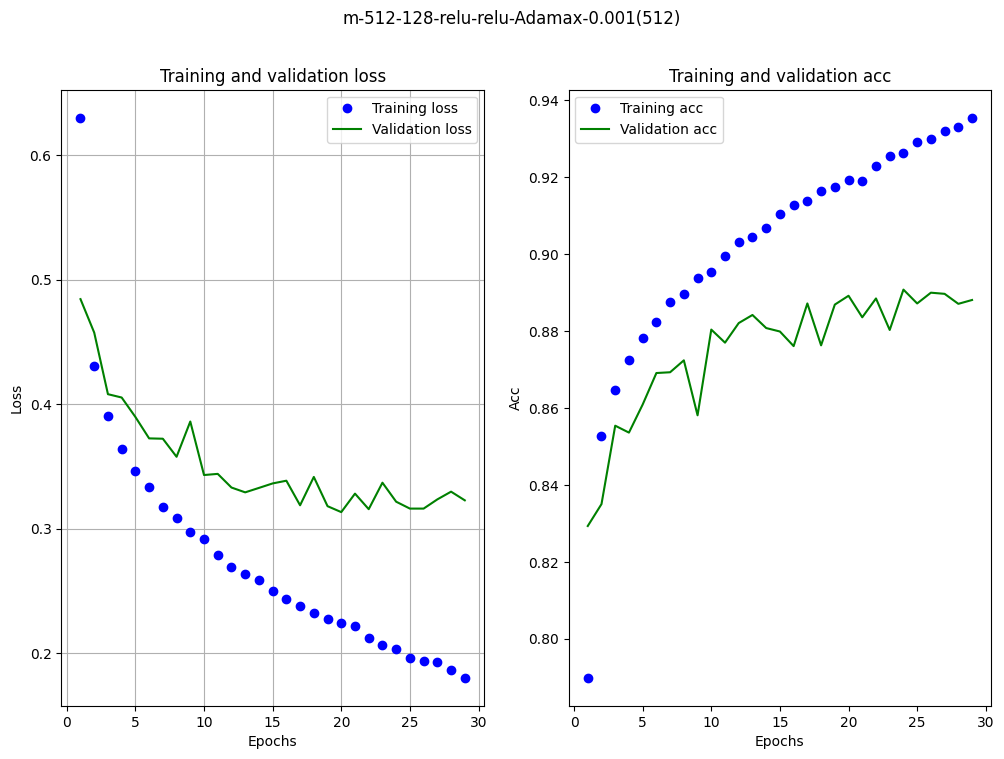

In [118]:
retest_NN(
          set_layers=[NUM_FEATURES, 512, 128, NUM_CLASSES], 
          act=['relu', 'relu', 'softmax'], 
          opt=optimizers.legacy.Adamax, 
          lr=0.001,
          bs=512,
          epochs=29
          )